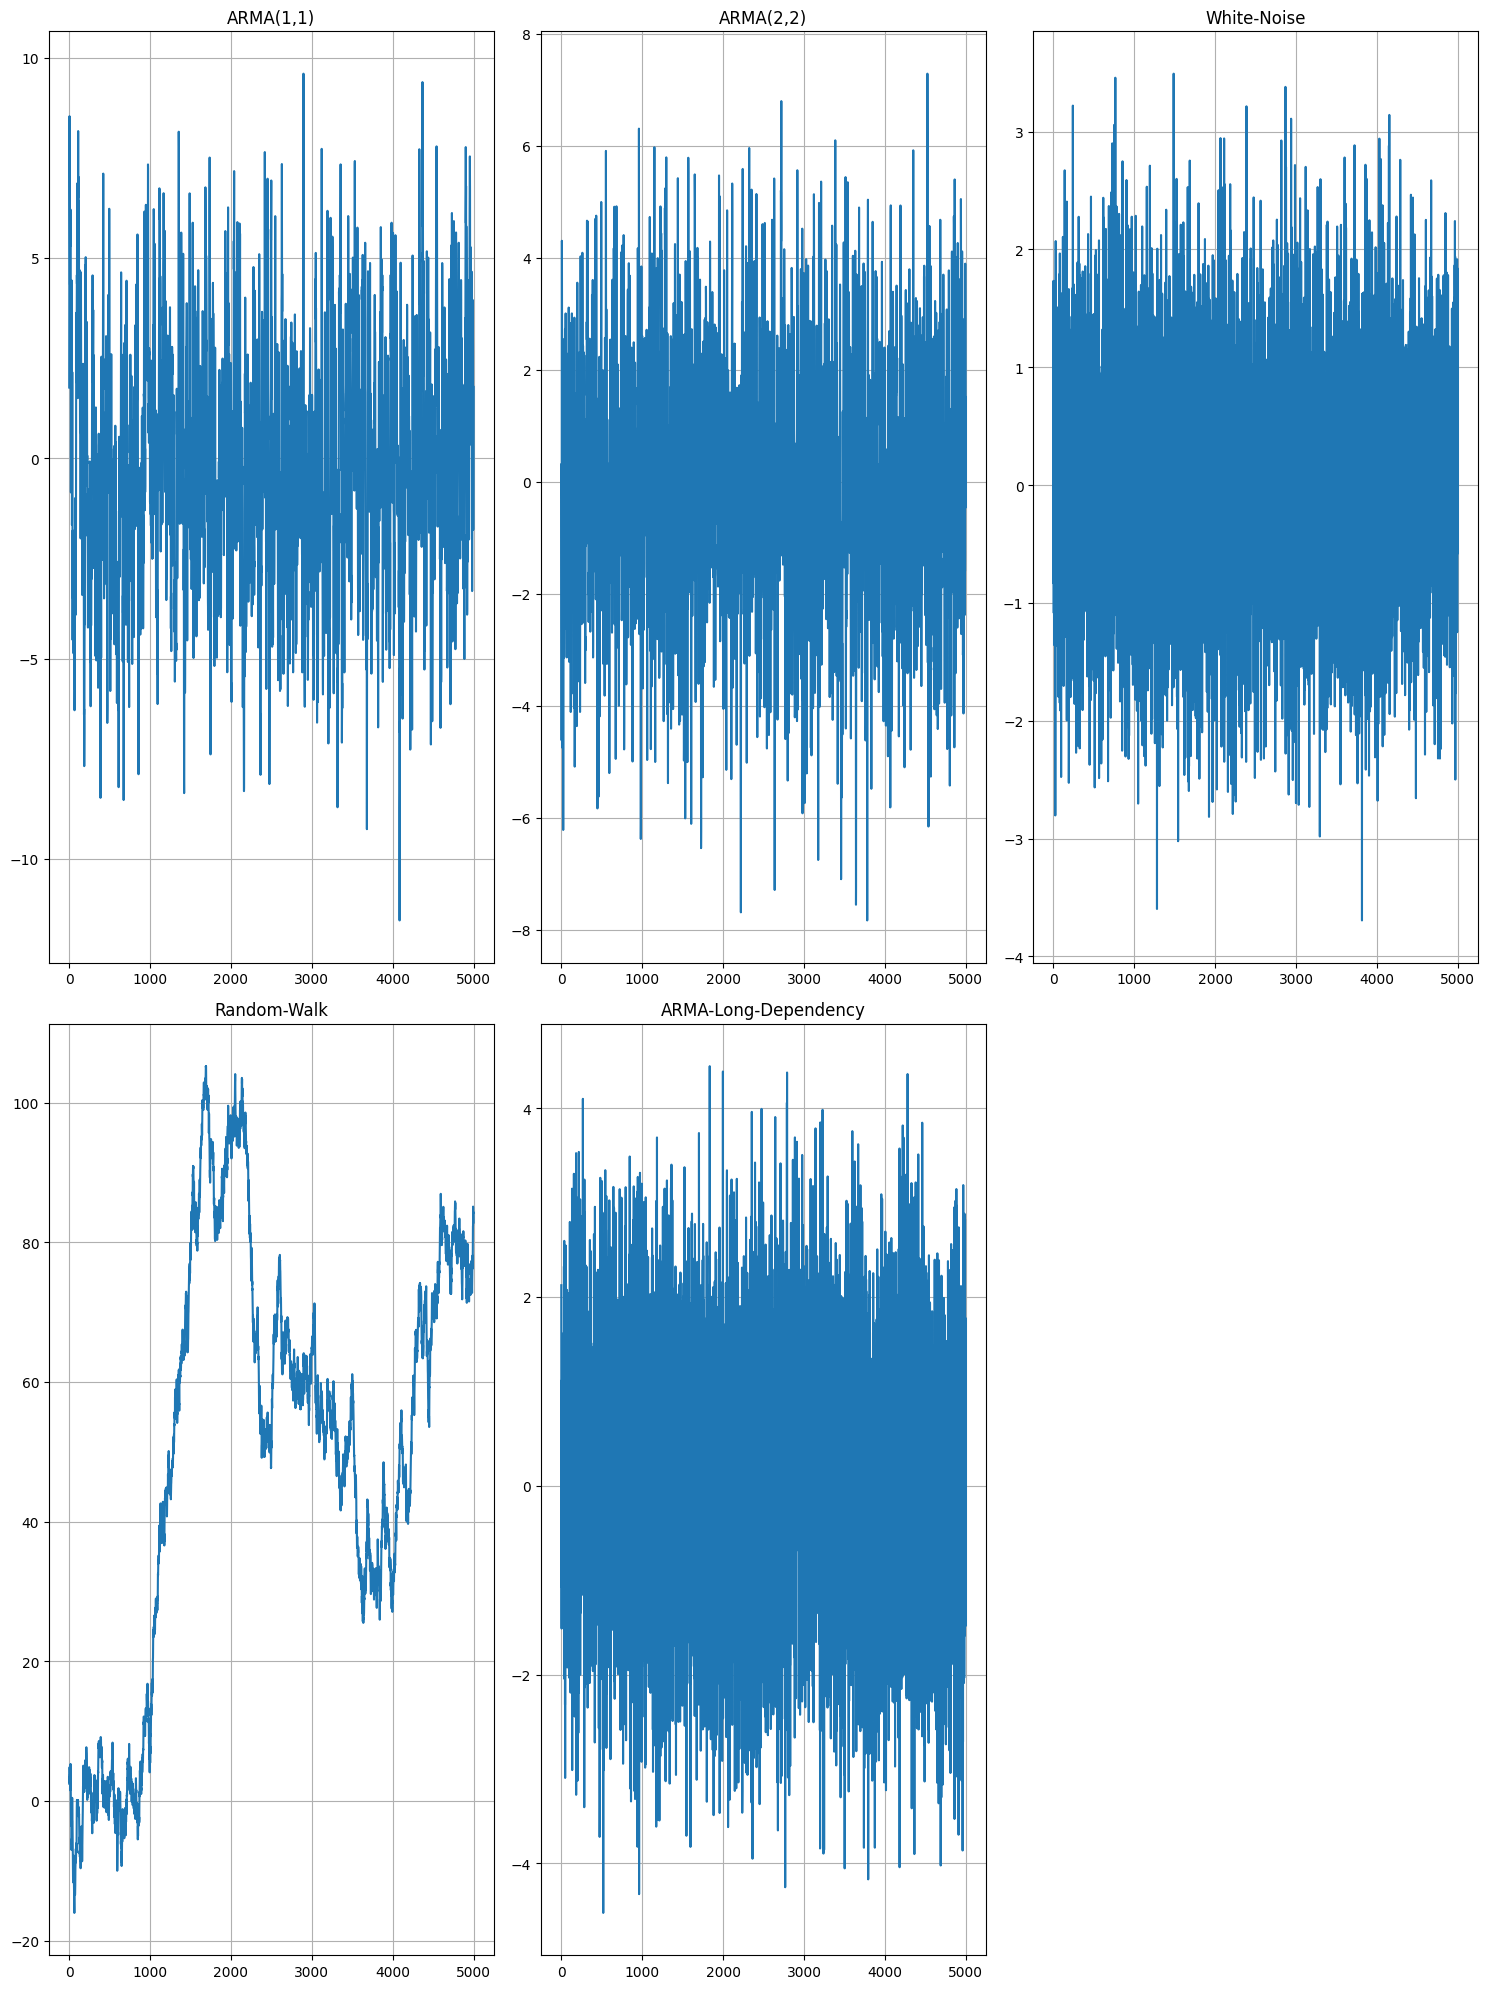

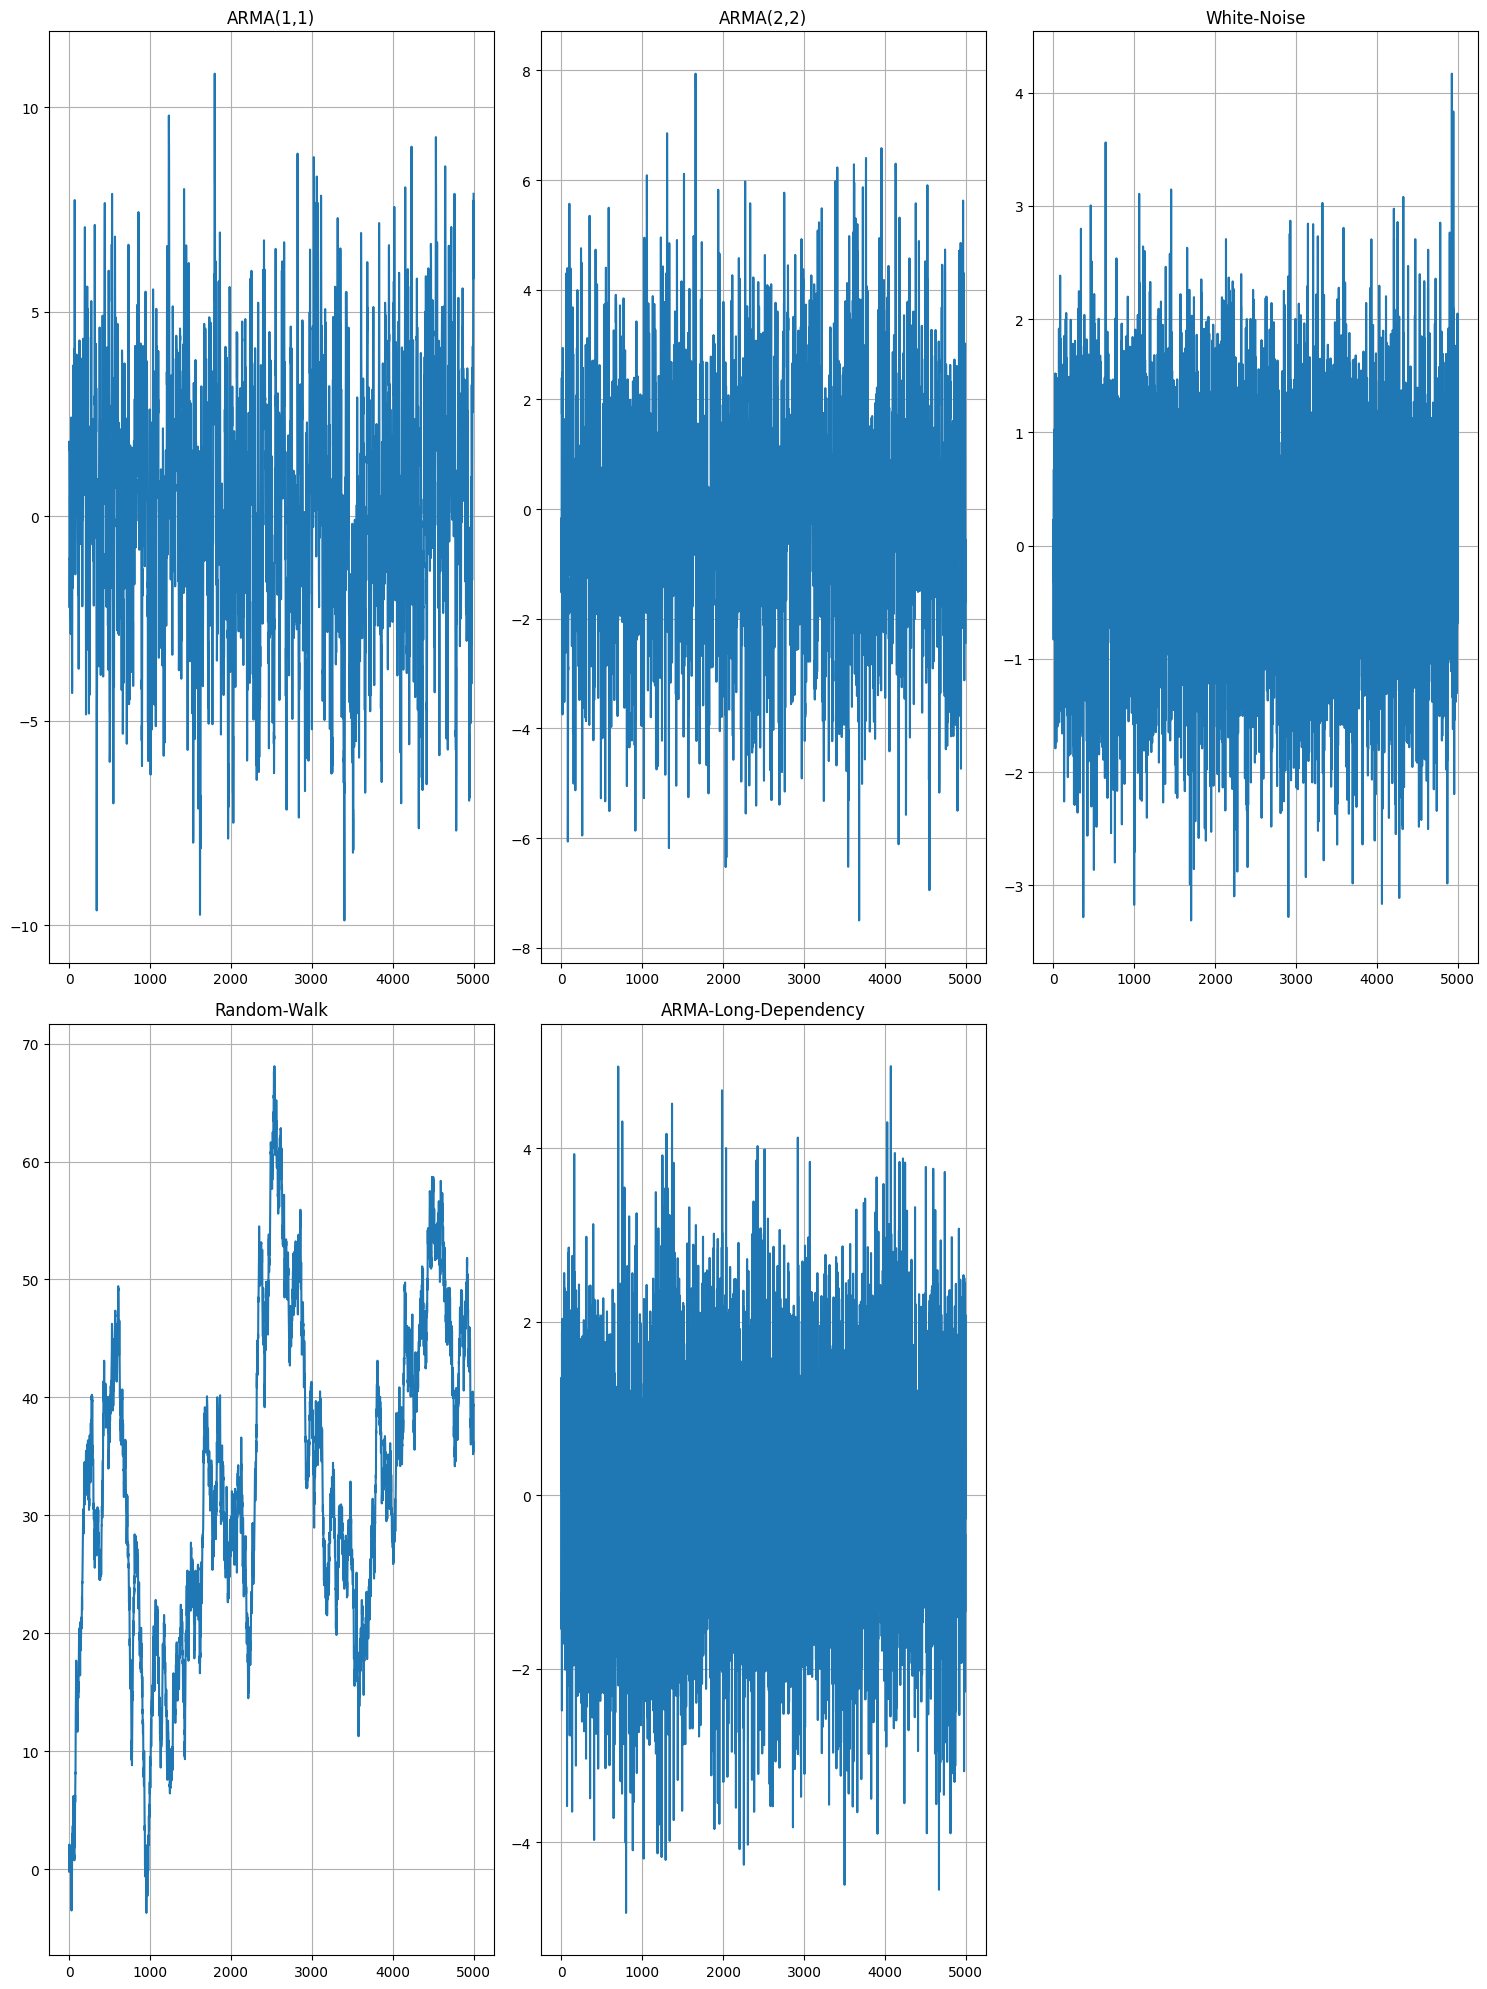

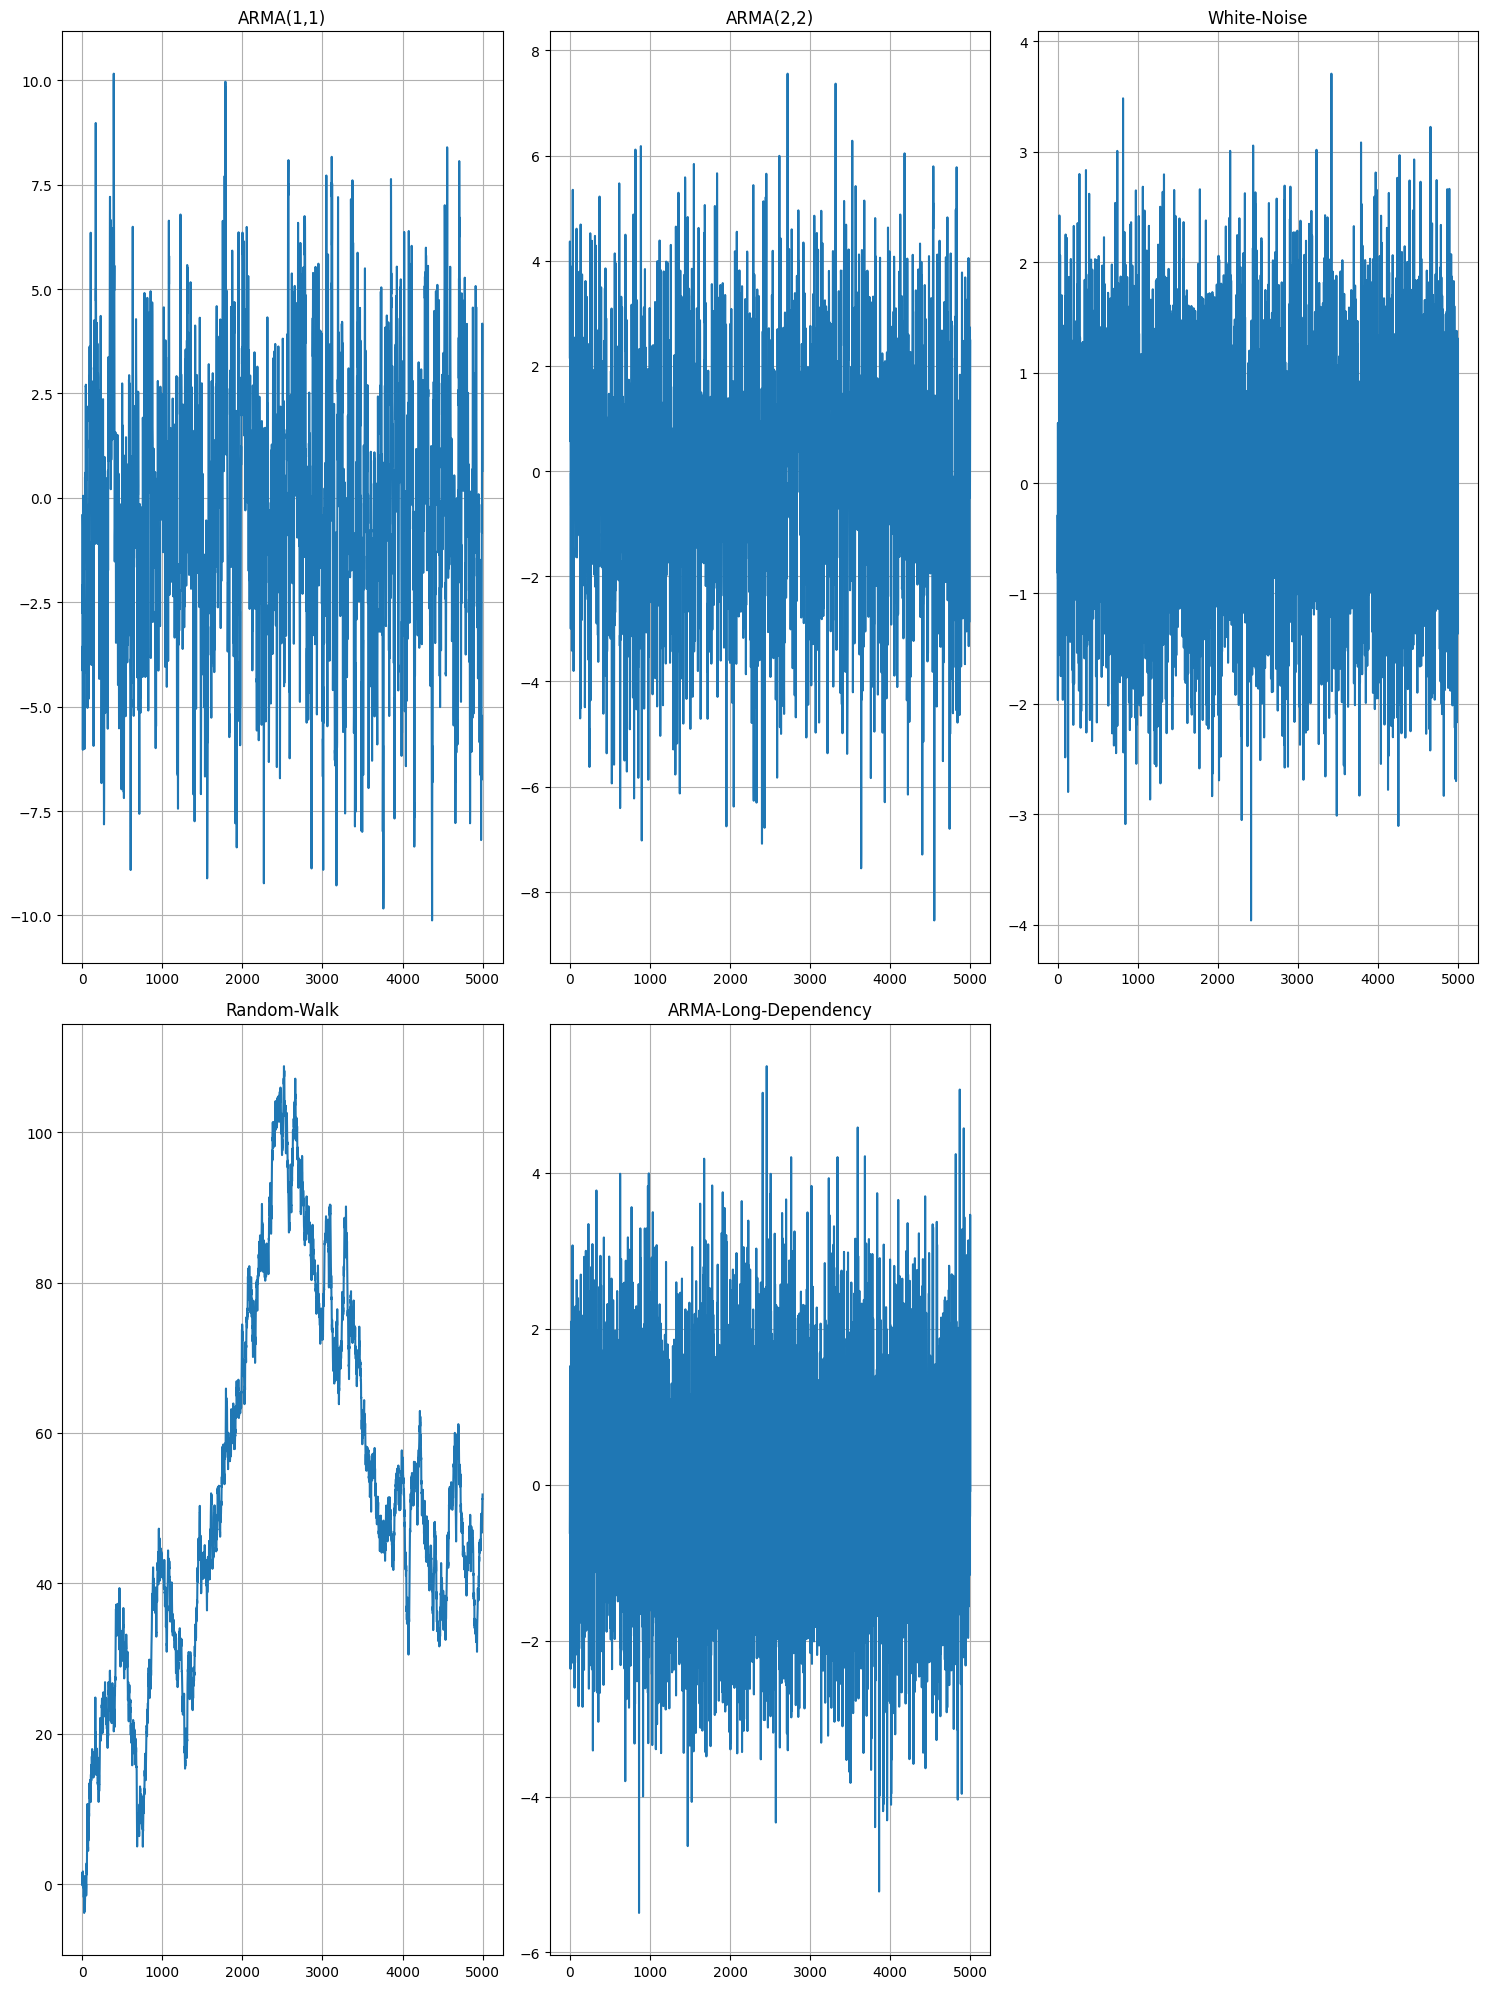

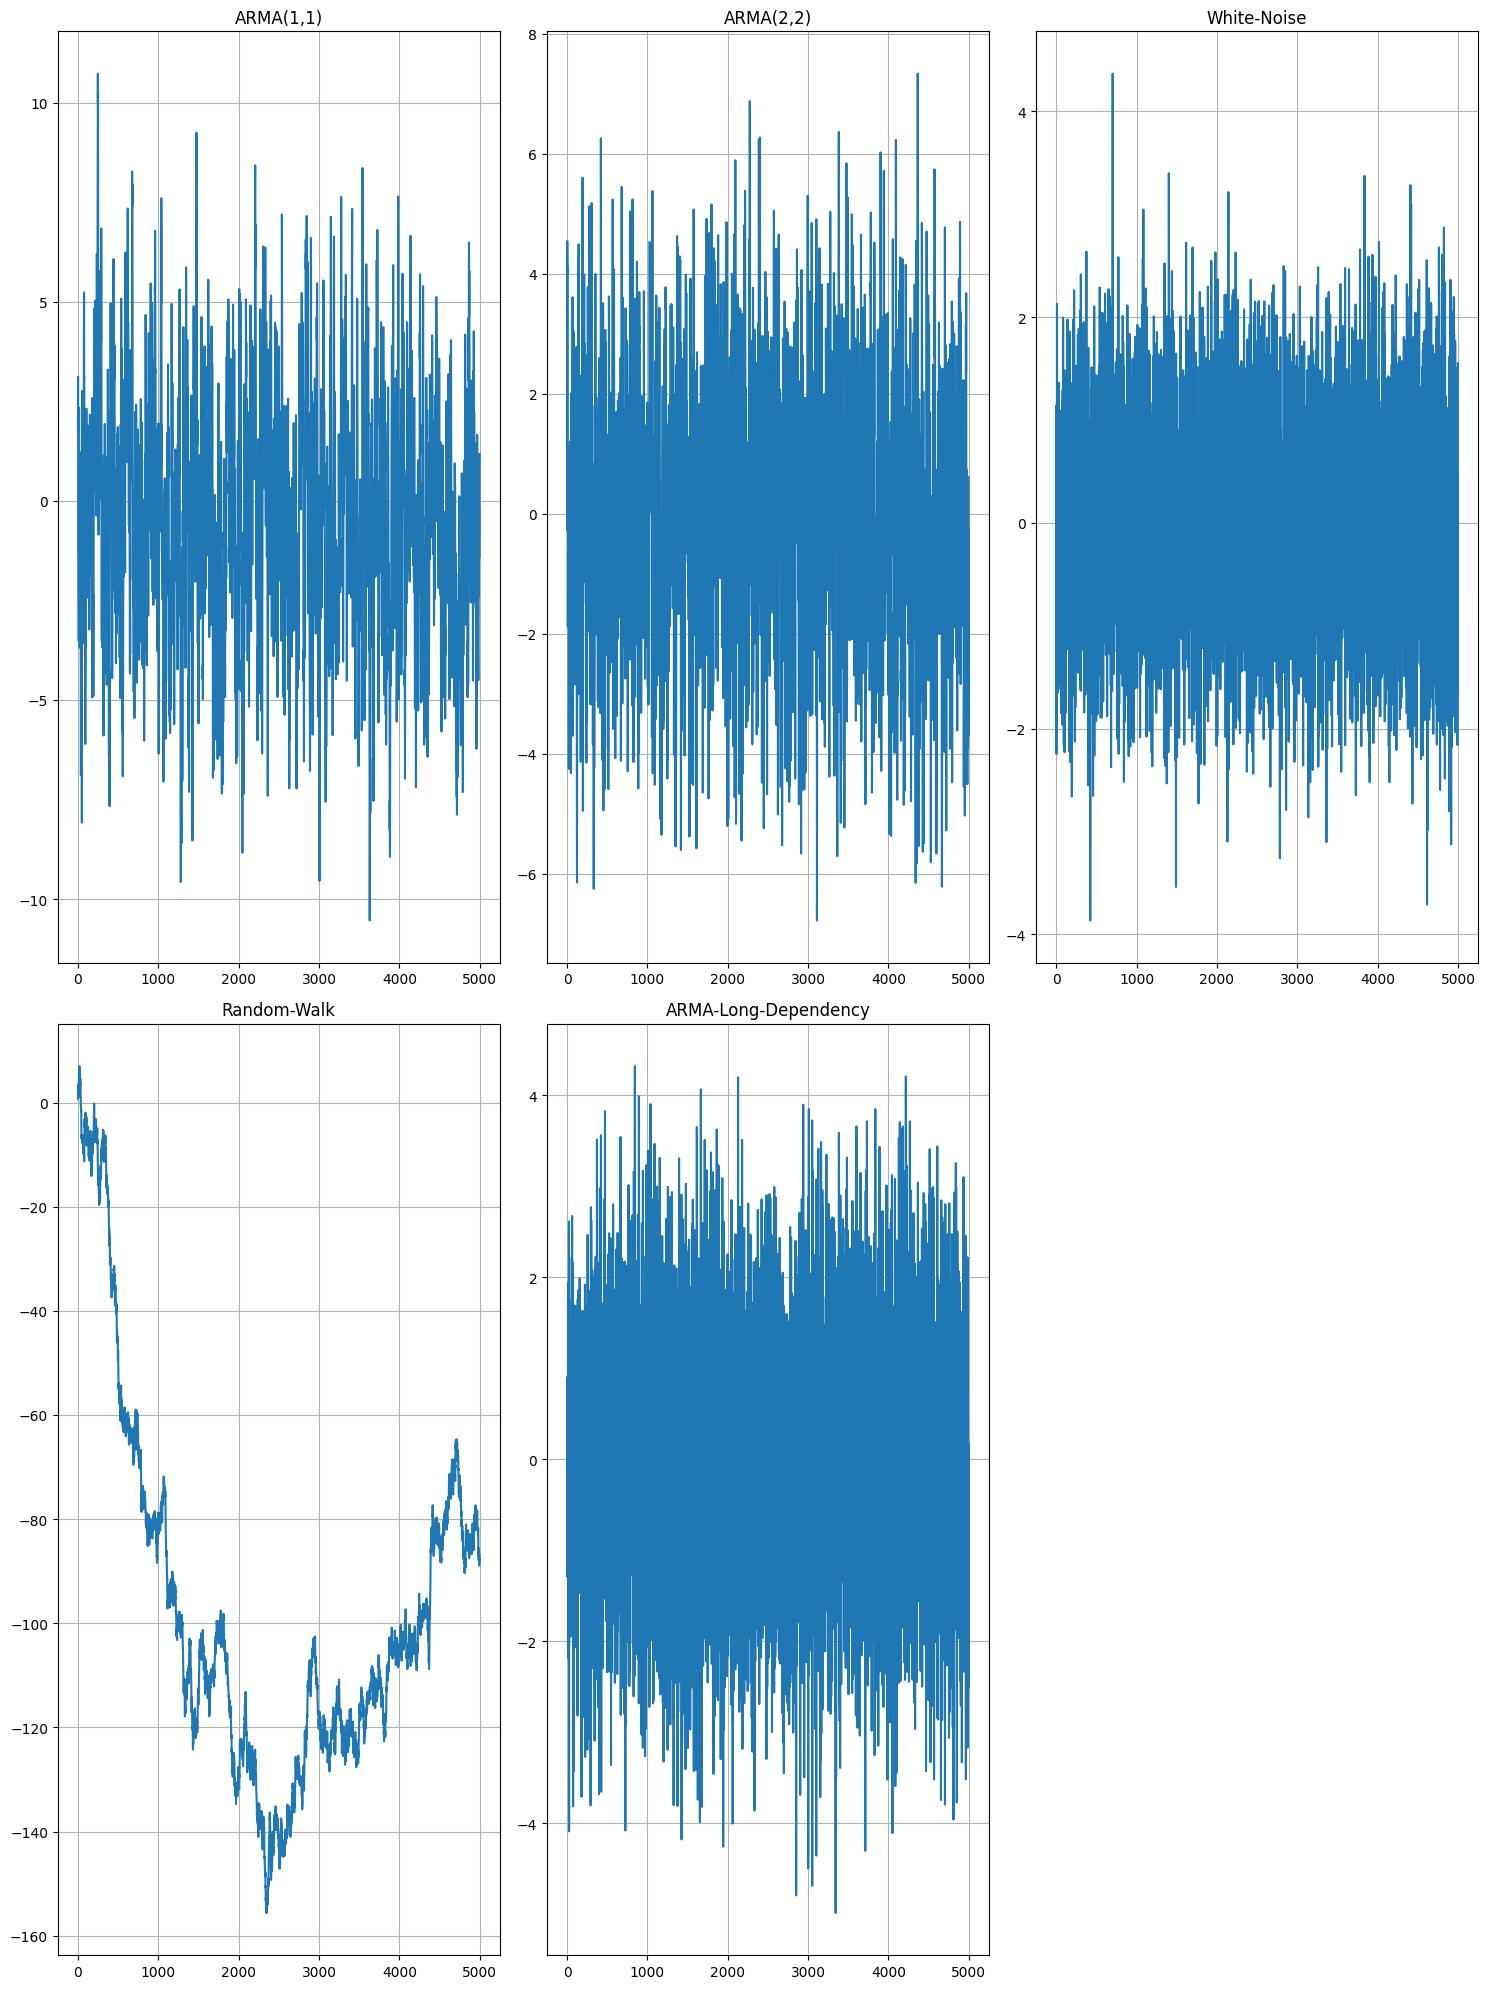

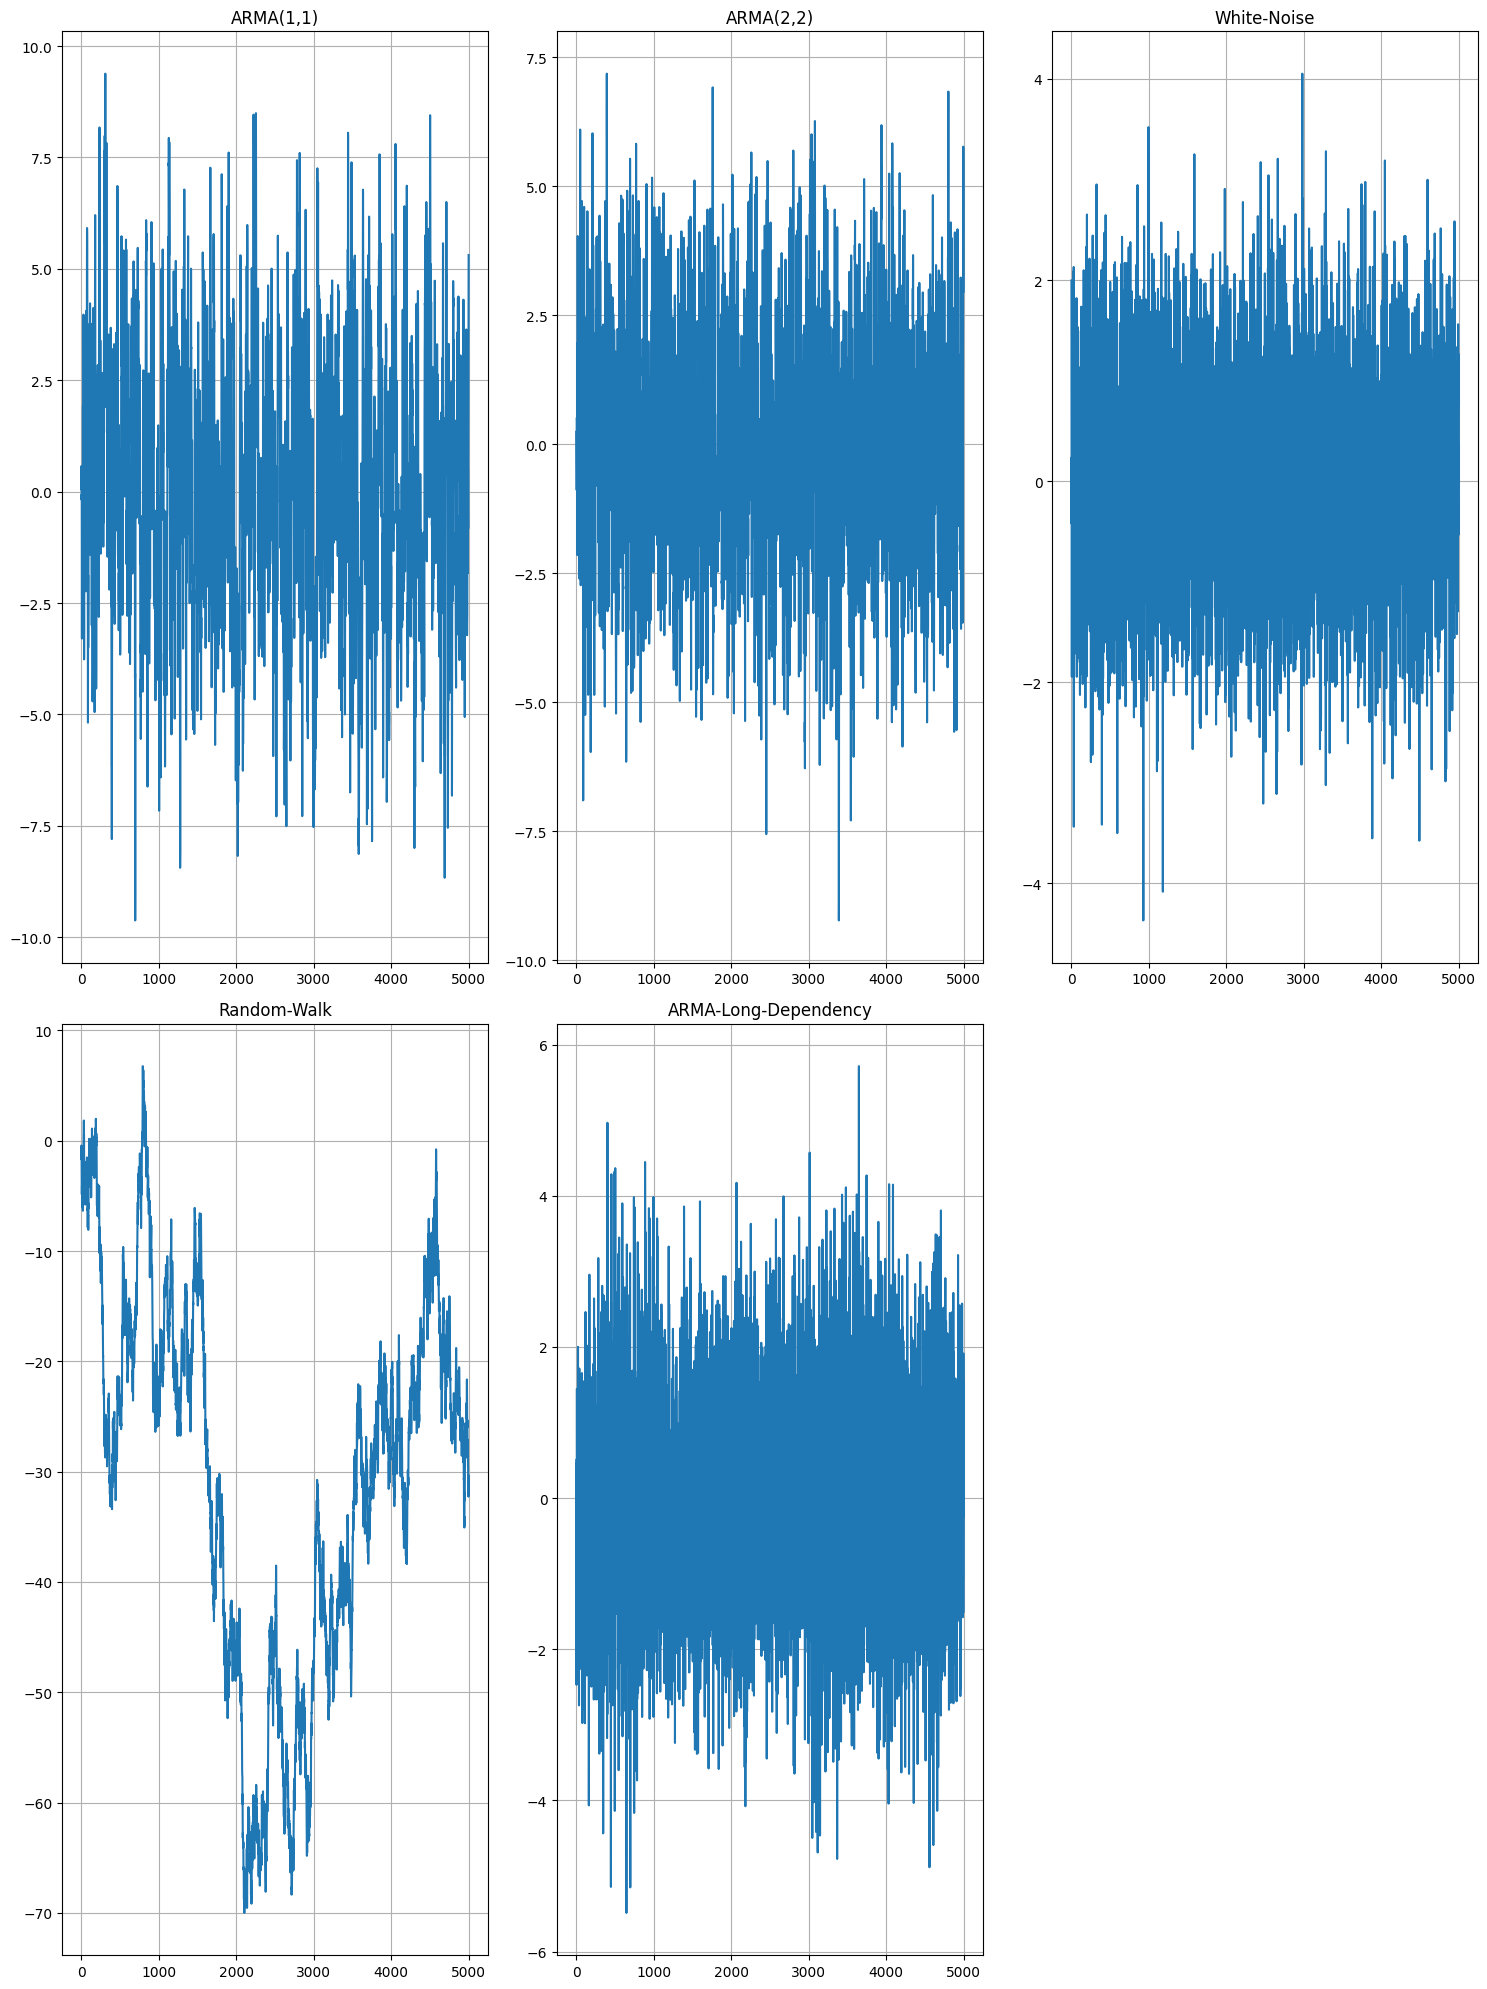

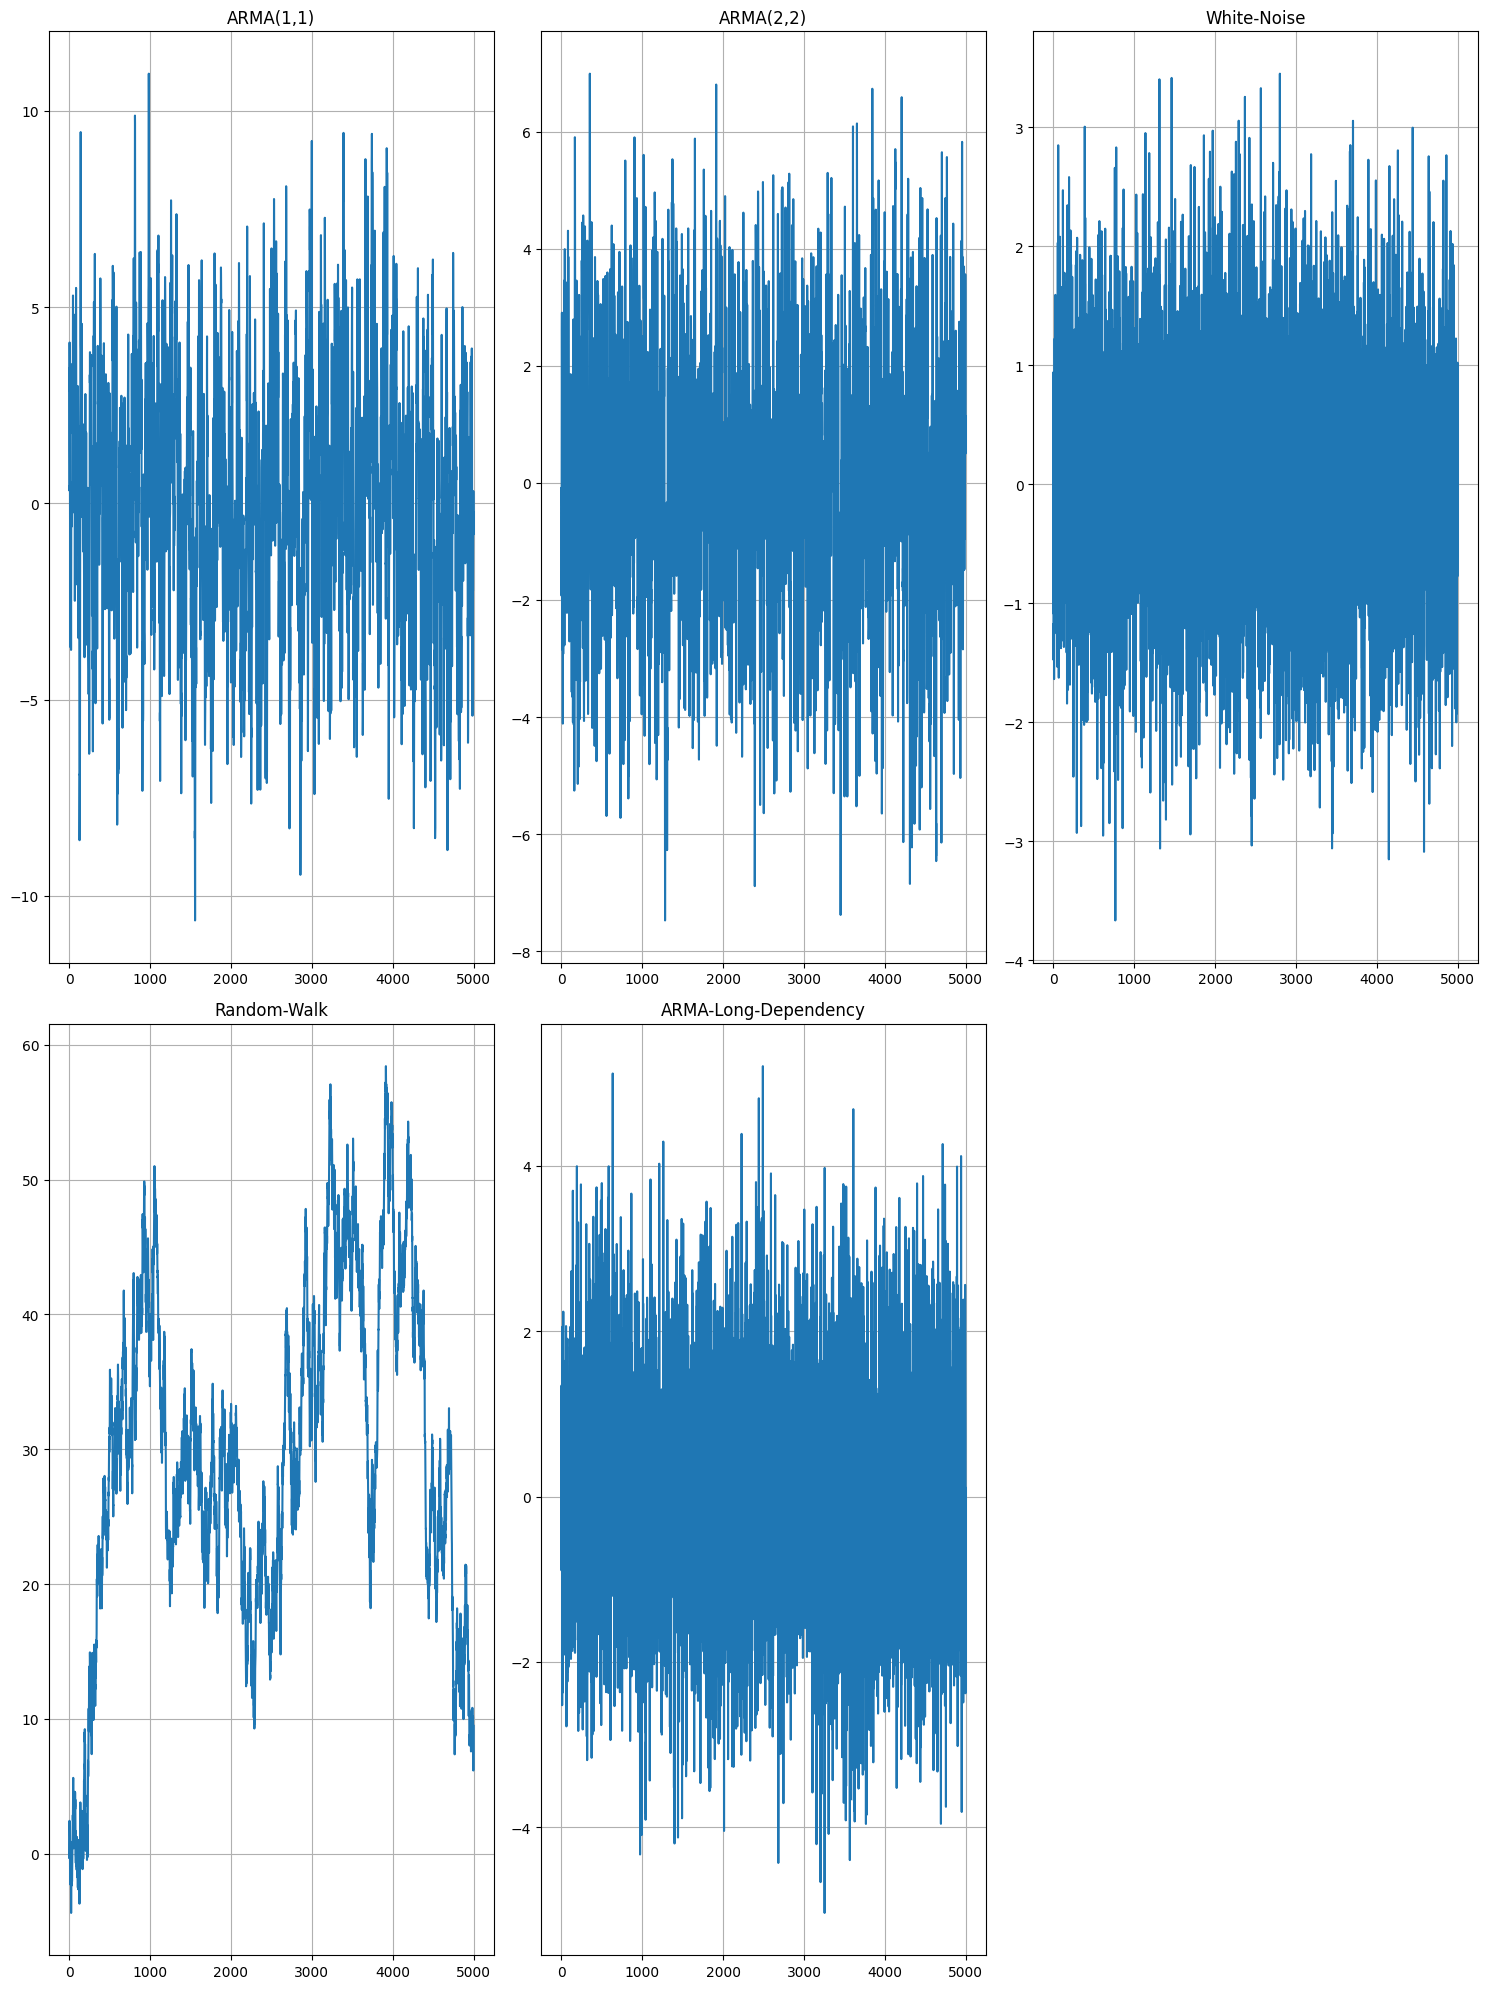

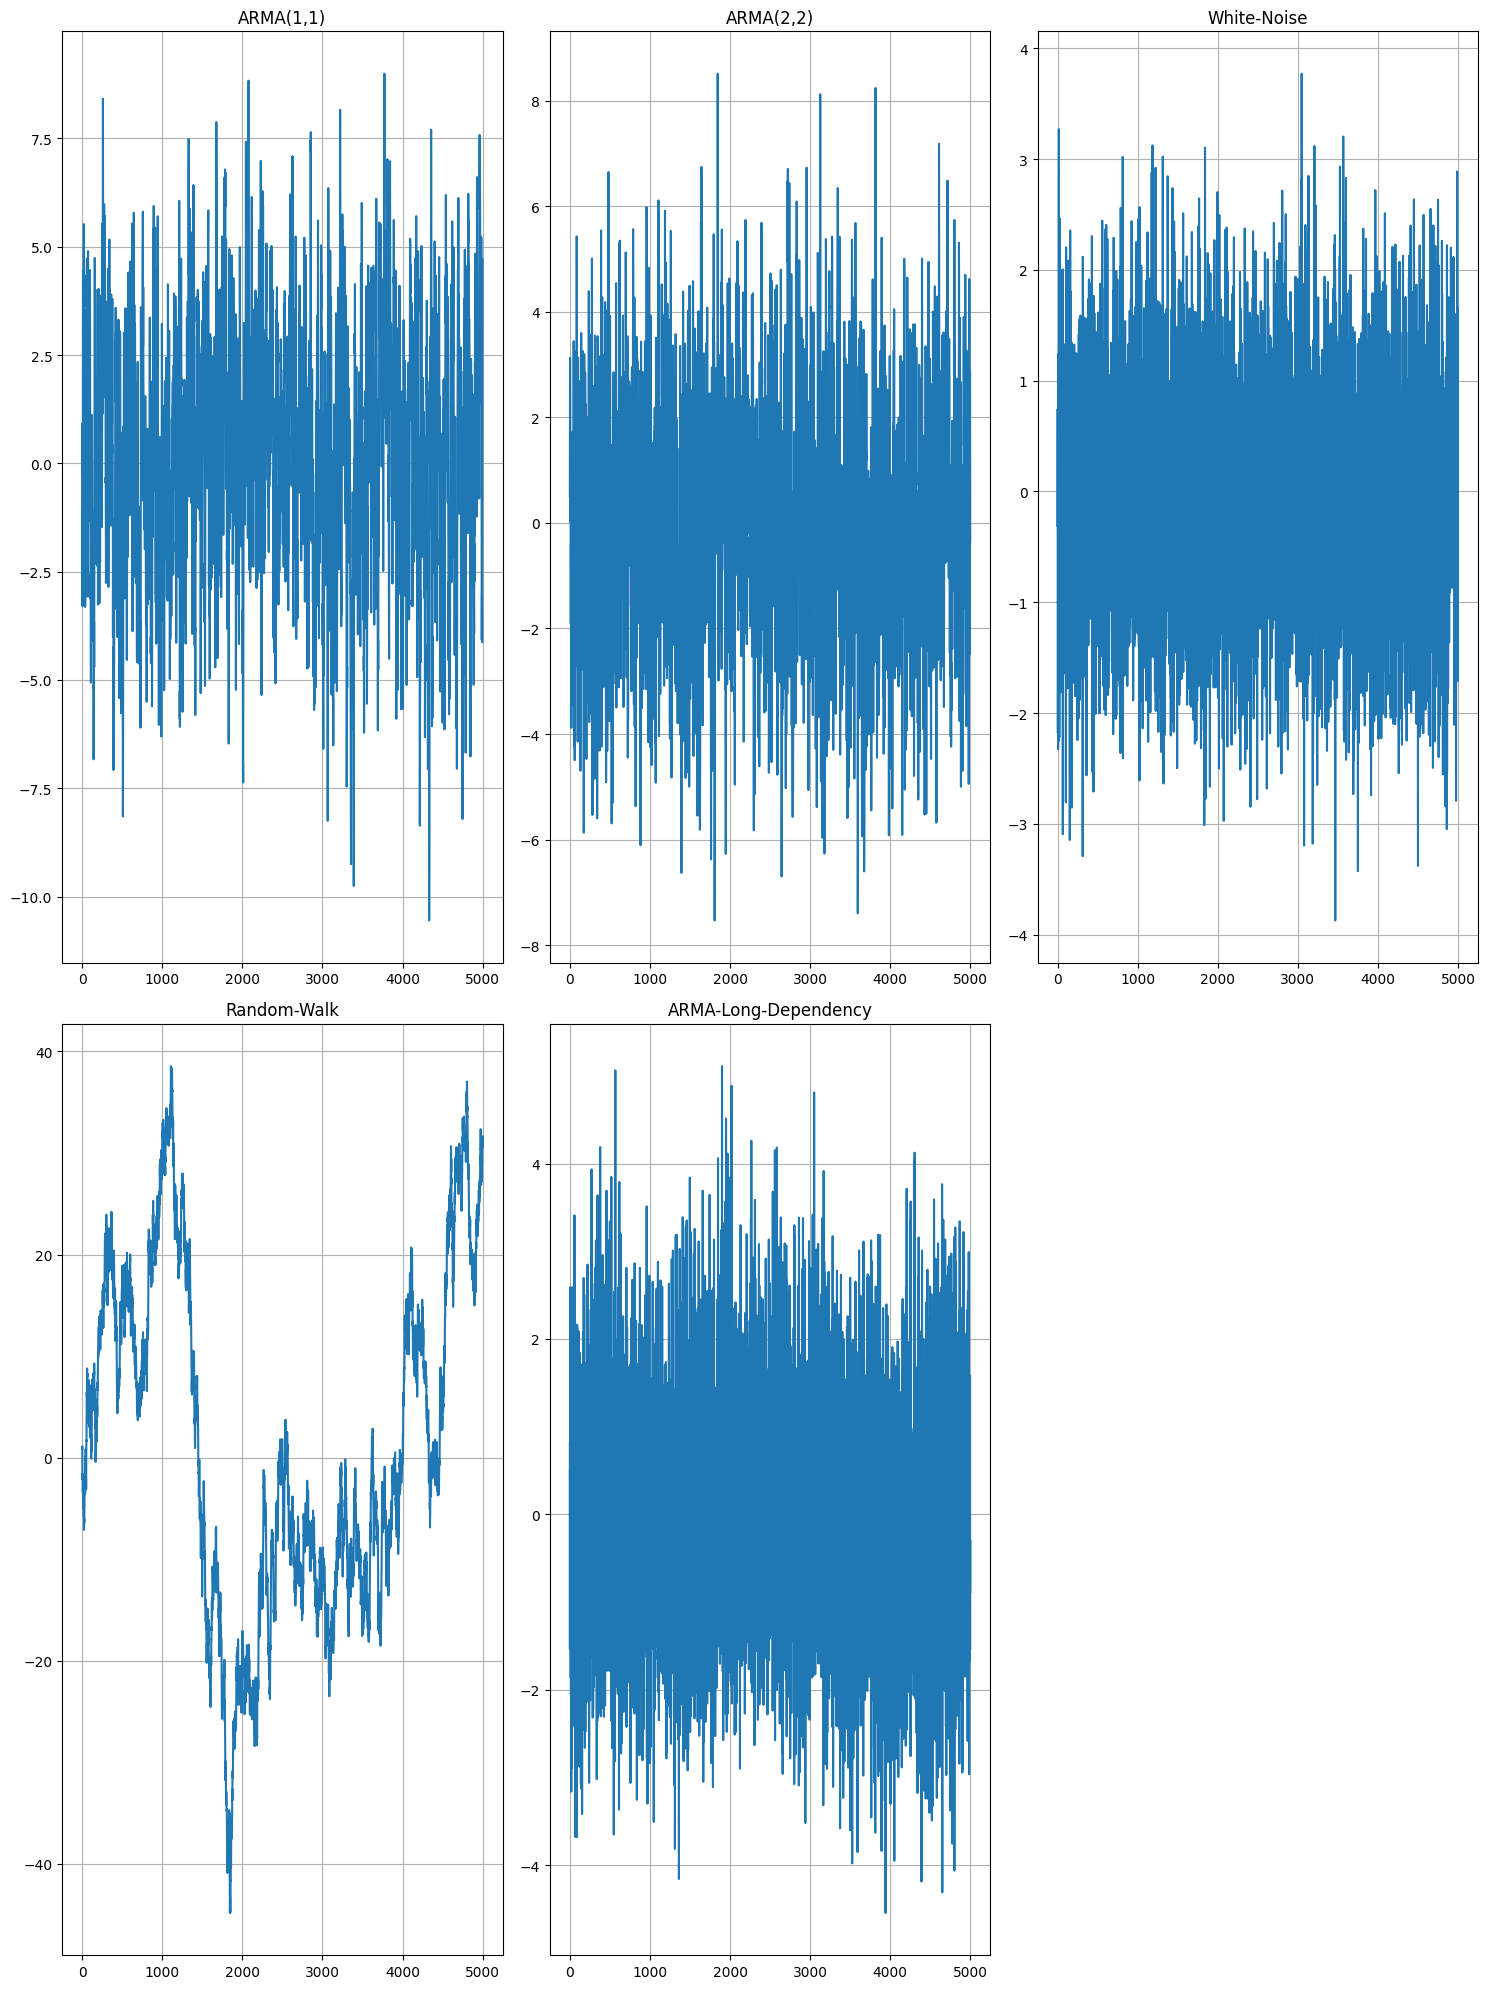

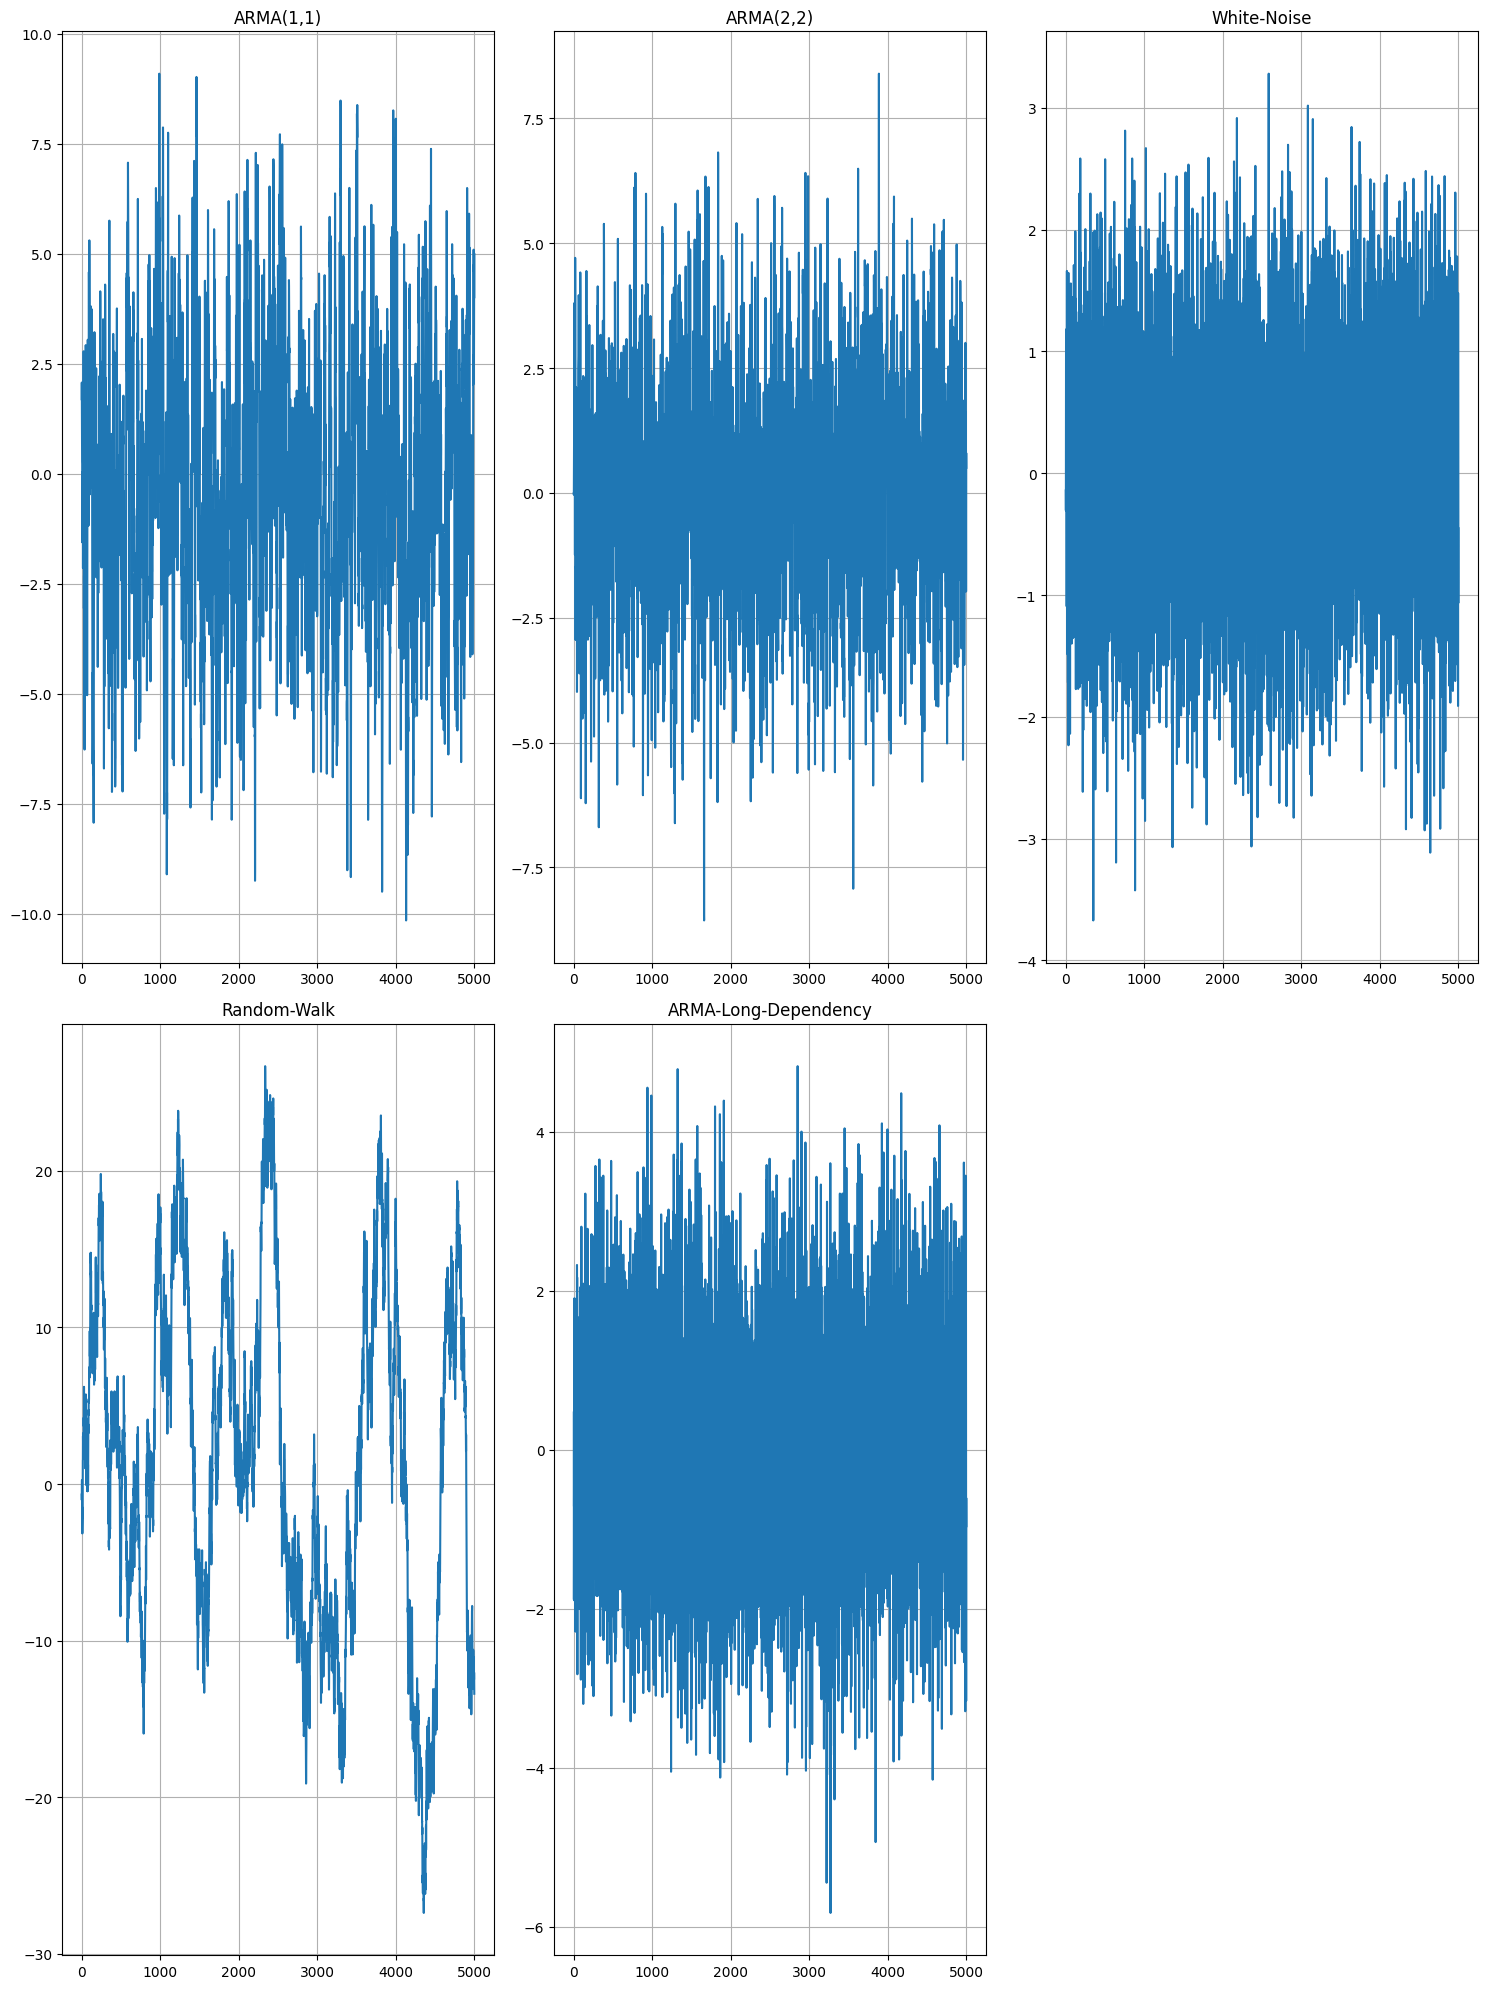

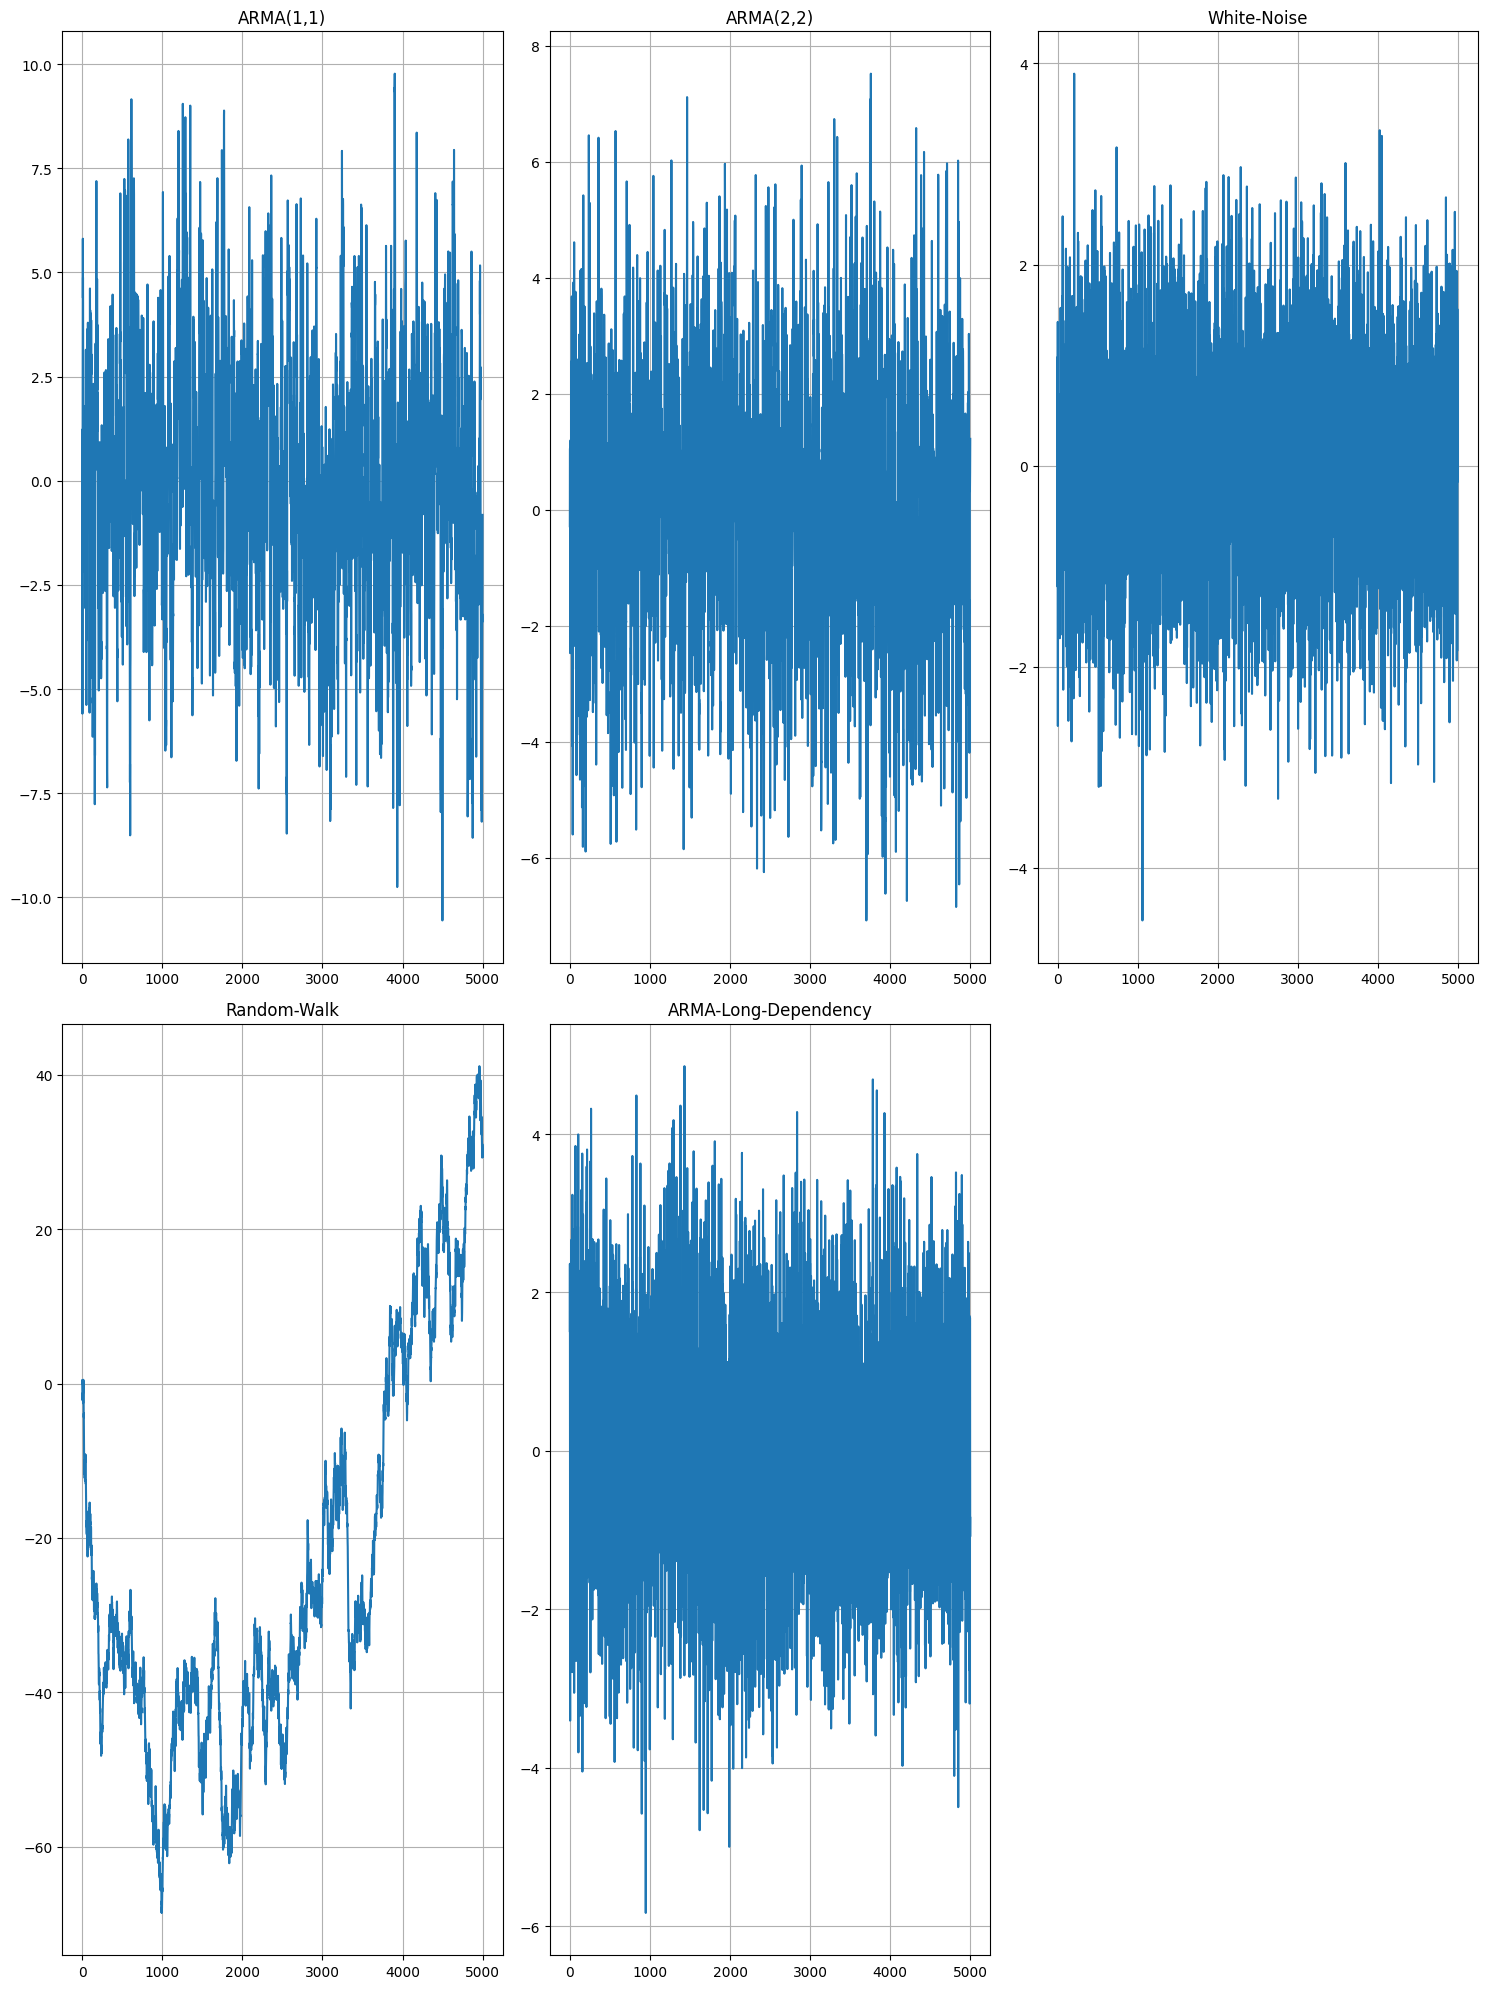

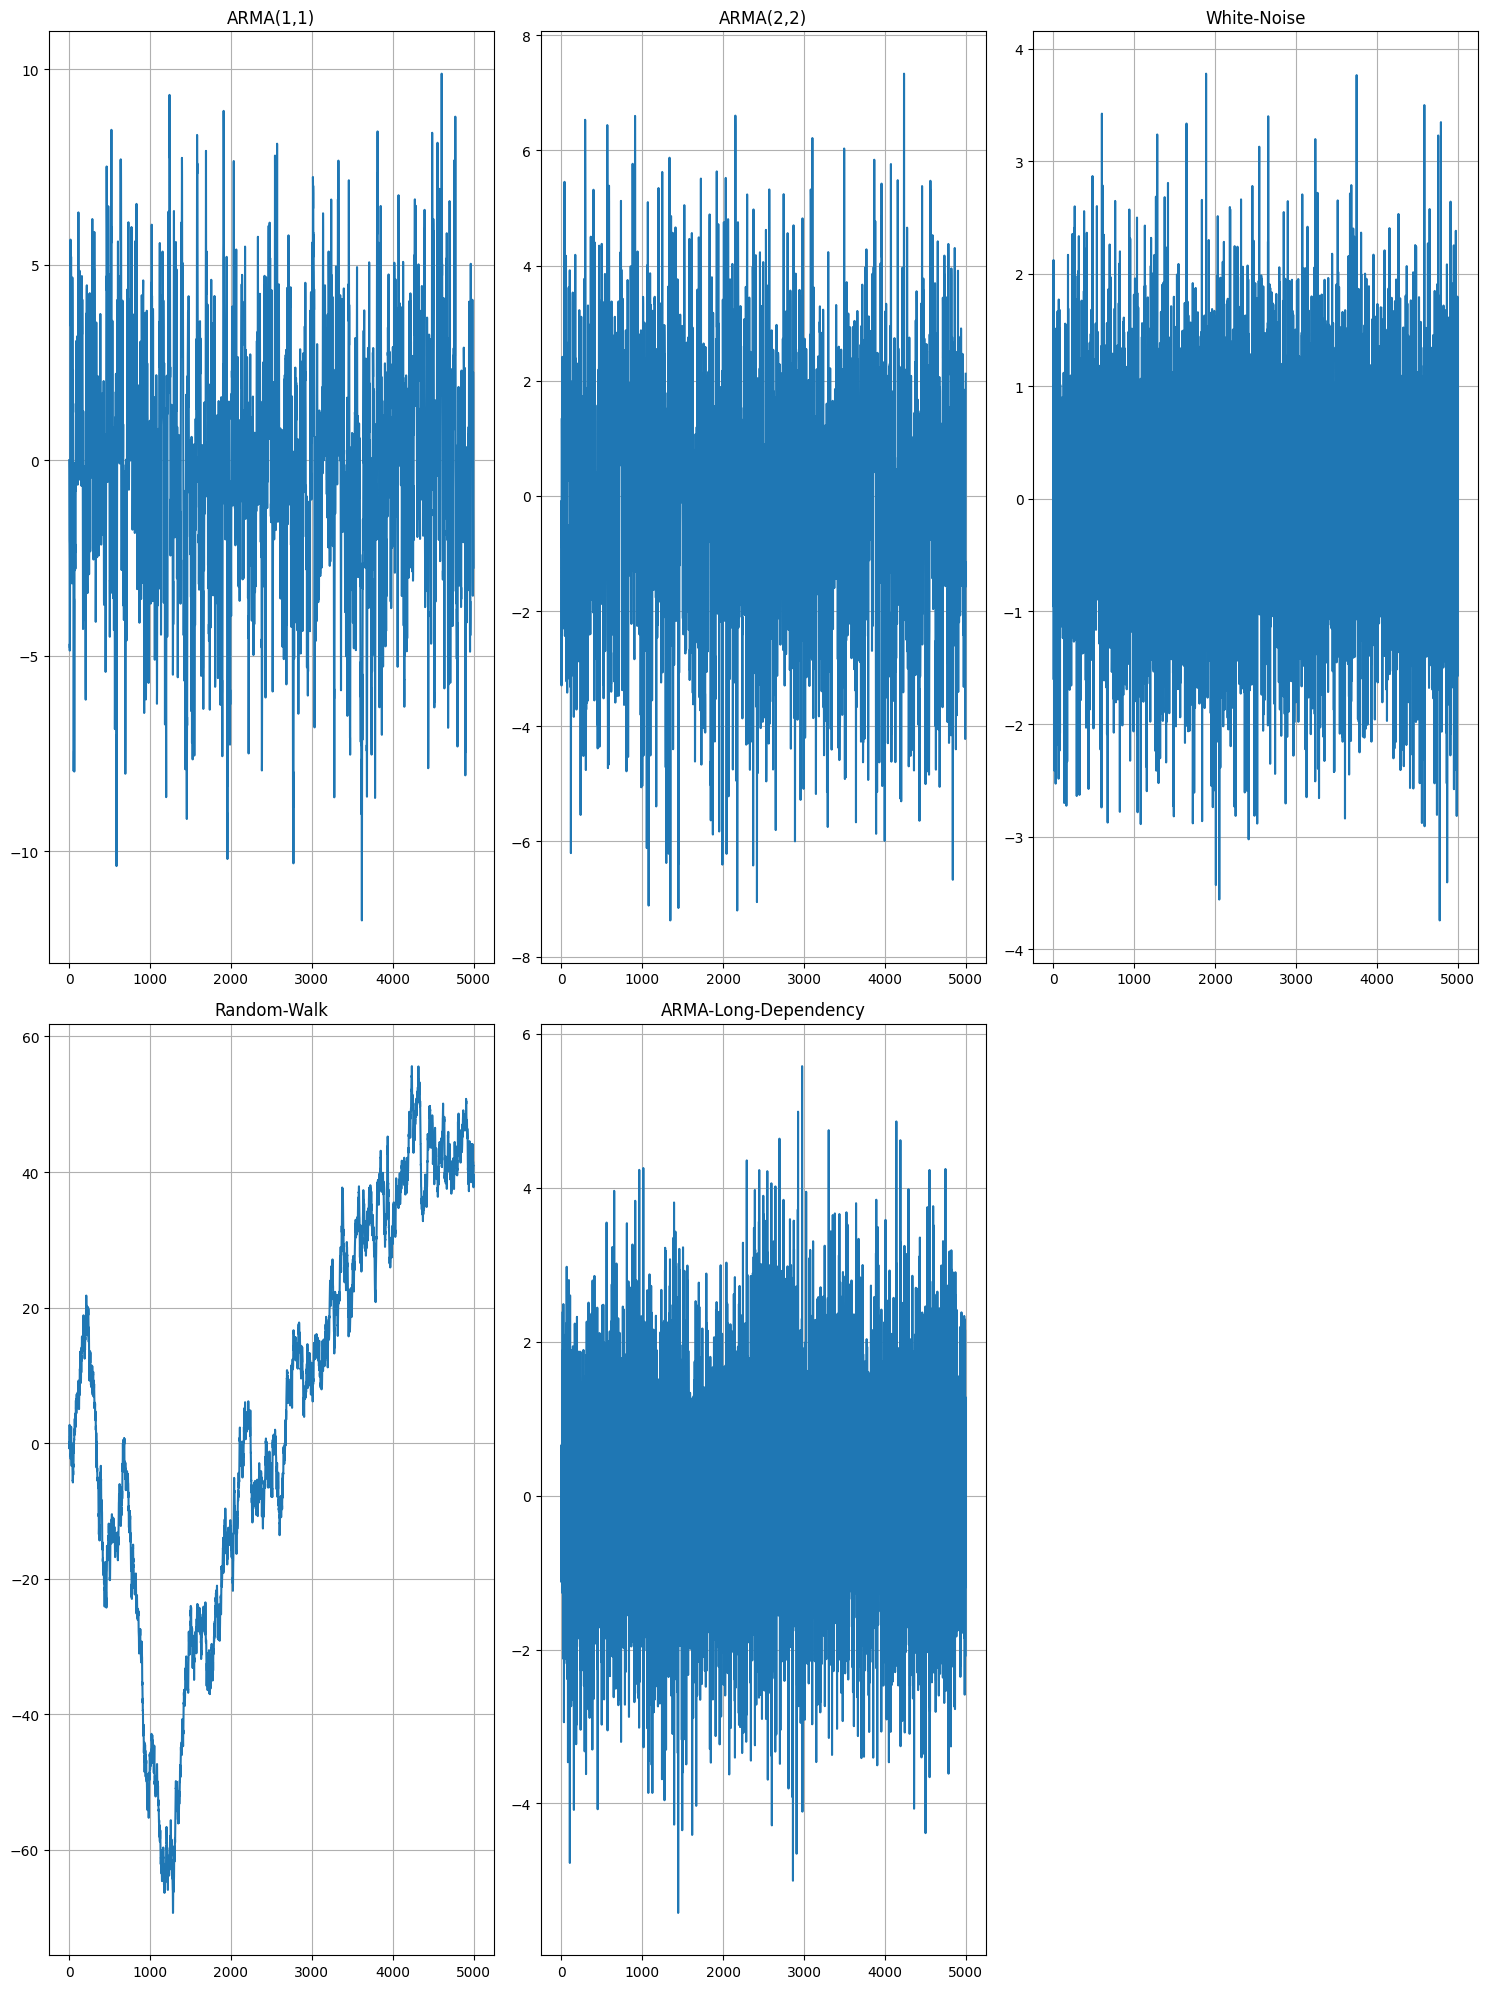

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

def generate_long_dependency_arma(n, lag=50, ar_coef=0.7, ma_params=None):
    """
    Generate an ARMA process with long-term dependency where only the specified lag
    has a non-zero coefficient, creating a time series that depends only on values
    'lag' time steps in the past.
    
    Parameters:
    n (int): Length of the signal
    lag (int): The specific lag with non-zero coefficient (default=50)
    ar_coef (float): Coefficient value for the lag (abs value must be < 1 for stationarity)
    ma_params (list): Optional MA parameters (default=None)
    
    Returns:
    numpy.ndarray: Time series with the specified long-term dependency
    """
    # Create an array with zeros for all AR coefficients except at position 'lag'
    ar_params = np.zeros(lag)
    ar_params[lag-1] = ar_coef  # -1 because Python uses 0-based indexing
    
    # Default MA parameters if none provided
    if ma_params is None:
        ma_params = [0]
    
    # Generate the ARMA process - need to handle the statsmodels AR parameter format
    arma_process = ArmaProcess(ar=np.r_[1, -ar_params], ma=np.r_[1, np.array(ma_params)])
    
    # Generate longer signal to allow burn-in period for the dependencies to manifest
    extended_n = n + lag * 2
    signal = arma_process.generate_sample(nsample=extended_n)
    
    # Return only the latter portion after burn-in
    return signal[lag*2:]


# Basic signal generation functions
def generate_linear_signal(n, slope=10, intercept=0):
    x = np.arange(n)
    return slope * x + intercept

def generate_quadratic_signal(n, a=1, b=1, c=1):
    x = np.arange(n)
    return a * x ** 2 + b * x + c

def generate_exponential_signal(n, rate=0.01, a=1):
    x = np.arange(n)
    return a*np.exp(rate * x) + 1

def generate_logarithmic_signal(n, base=2):
    x = np.arange(1, n + 1)
    return np.log(x) / np.log(base)

def generate_logistic_signal(n, L=1, k=0.1, t0=None):
    """
    Generate a logistic (sigmoid) function signal representing S-shaped growth.
    
    Parameters:
    n (int): Length of the signal
    L (float): The curve's maximum value
    k (float): The growth rate or steepness of the curve
    t0 (float): The time of the sigmoid's midpoint (defaults to n/2)
    """
    if t0 is None:
        t0 = n / 2
        
    x = np.arange(n)
    return L / (1 + np.exp(-k * (x - t0)))

def generate_gompertz_signal(n, a=1, b=2, k=0.1):
    """
    Generate a Gompertz function signal, used in biology and economics.
    
    Parameters:
    n (int): Length of the signal
    a (float): The asymptotic value
    b (float): Displacement along the x-axis
    k (float): Growth rate
    """
    x = np.arange(n)
    return a * np.exp(-b * np.exp(-k * x))

def generate_power_law_signal(n, a=1, b=0.5):
    """
    Generate a power law signal for scaling relationships.
    
    Parameters:
    n (int): Length of the signal
    a (float): Scale parameter
    b (float): Power exponent
    """
    x = np.arange(1, n + 1)  # Avoid x=0 if b<0
    return a * x**b

def generate_step_signal(n, t0=None, c=0, d=1):
    """
    Generate a step function signal representing a sudden change.
    
    Parameters:
    n (int): Length of the signal
    t0 (int): Step transition point (defaults to n/2)
    c (float): Value before step
    d (float): Value after step
    """
    if t0 is None:
        t0 = n // 2
        
    signal = np.ones(n) * c
    signal[t0:] = d
    return signal

def generate_piecewise_linear_signal(n, breakpoints, values):
    """
    Generate a piecewise linear signal with specified values at breakpoints.
    
    Parameters:
    n (int): Length of the signal
    breakpoints (list): List of x-indices where values are specified
    values (list): List of y-values at the breakpoints
    """
    assert len(breakpoints) == len(values), "Number of breakpoints must equal number of values"
    
    # Add endpoints if not present
    if 0 not in breakpoints:
        breakpoints = [0] + list(breakpoints)
        values = [values[0]] + list(values)
    if n-1 not in breakpoints:
        breakpoints = list(breakpoints) + [n-1]
        values = list(values) + [values[-1]]
    
    # Sort by breakpoints
    bp_values = sorted(zip(breakpoints, values))
    sorted_bp = [bp for bp, _ in bp_values]
    sorted_values = [val for _, val in bp_values]
    
    # Create signal using linear interpolation
    signal = np.zeros(n)
    for i in range(len(sorted_bp) - 1):
        start_idx = sorted_bp[i]
        end_idx = sorted_bp[i + 1]
        start_val = sorted_values[i]
        end_val = sorted_values[i + 1]
        
        # Linear interpolation
        if end_idx > start_idx:
            for j in range(start_idx, end_idx + 1):
                t = (j - start_idx) / (end_idx - start_idx)
                signal[j] = (1 - t) * start_val + t * end_val
    
    return signal

def generate_gaussian_signal(n, a=1, t0=None, sigma=None):
    """
    Generate a Gaussian (bell curve) signal.
    
    Parameters:
    n (int): Length of the signal
    a (float): Peak amplitude
    t0 (float): Center position (defaults to n/2)
    sigma (float): Standard deviation (defaults to n/10)
    """
    if t0 is None:
        t0 = n / 2
    if sigma is None:
        sigma = n / 10
        
    x = np.arange(n)
    return a * np.exp(-((x - t0)**2) / (2 * sigma**2))

# Wave and oscillatory signal functions
def generate_sine_wave(n, amplitude=1, frequency=0.5, phase=0):
    x = np.arange(n)
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def generate_composite_sine(n, components):
    """
    Generate a signal composed of multiple sine waves.
    
    Parameters:
    n (int): Length of the signal
    components (list): List of tuples, each containing (amplitude, frequency, phase_shift, wave_type)
                      where wave_type is 'sin' or 'cos' (defaults to 'sin' if not specified)
    
    Returns:
    numpy.ndarray: The composite signal
    """
    x = np.arange(n)
    signal = np.zeros(n)
    
    for component in components:
        if len(component) == 3:
            amplitude, frequency, phase_shift = component
            wave_type = 'sin'
        elif len(component) == 4:
            amplitude, frequency, phase_shift, wave_type = component
        else:
            raise ValueError("Each component must be a tuple of (amplitude, frequency, phase_shift) or (amplitude, frequency, phase_shift, wave_type)")
        
        if wave_type.lower() == 'sin':
            signal += amplitude * np.sin(2 * np.pi * frequency * x + phase_shift)
        elif wave_type.lower() == 'cos':
            signal += amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)
        else:
            raise ValueError("wave_type must be 'sin' or 'cos'")
            
    return signal

def generate_cosine_wave(n, amplitude=1, frequency=0.5, phase=0):
    x = np.arange(n)
    return amplitude * np.cos(2 * np.pi * frequency * x + phase)

def generate_triangle_wave(n, amplitude=1, frequency=0.5):
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n), 0.5)

def generate_sawtooth_wave(n, amplitude=1, frequency=0.1, phase_shift=0.99):
    """
    Generate a sawtooth wave with consistent peak values.
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Peak amplitude of the wave
    frequency (float): Frequency of the wave
    phase_shift (float): Phase shift to align peaks with sample points (0-1)
    """
    # Phase shift ensures peaks align with discrete sample points
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n) + phase_shift * np.pi)

def generate_square_wave(n, amplitude=1, frequency=0.5):
    return amplitude * signal.square(2 * np.pi * frequency * np.arange(n))

def generate_sinc_wave(n, amplitude=1, frequency=1.0):
    """
    Generate a sinc wave (sin(x)/x)
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Amplitude of the wave
    frequency (float): Controls how quickly the sinc function decays (smaller = slower decay)
    """
    # Using a reasonable range for x to show the sinc function characteristics
    # Scale the range by frequency to control decay rate
    x = np.linspace(-8 * np.pi / frequency, 8 * np.pi / frequency, n)
    # Using numpy's sinc function (defined as sin(πx)/(πx))
    # Need to divide by π to get sin(x)/x
    return amplitude * np.sinc(x / np.pi)

def generate_exp_sine_wave(n, amplitude=1, frequency=0.5):
    """
    Generate an exponential sine wave (e^sin(x))
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Amplitude scaling factor
    frequency (float): Frequency of the sine component
    """
    x = np.arange(n)
    return amplitude * np.exp(np.sin(2 * np.pi * frequency * x))

# Stochastic process generators
def generate_autoregressive_signal(n, coeffs=[0.6, 0.2, 0.15], noise_std=1):
    ar_signal = np.zeros(n)
    for i in range(len(coeffs), n):
        ar_signal[i] = sum(coeff * ar_signal[i - j - 1] for j, coeff in enumerate(coeffs))
        ar_signal[i] += np.random.normal(0, noise_std)
    return ar_signal

def generate_arma_signal(n, ar_params, ma_params):
    arma_process = ArmaProcess(ar=np.r_[1, -np.array(ar_params)], ma=np.r_[1, np.array(ma_params)])
    return arma_process.generate_sample(nsample=n)

def generate_random_walk(n, start=0):
    steps = np.random.normal(0, 1, n)
    return np.cumsum(steps) + start

def generate_white_noise(n, mean=0, std=1):
    return np.random.normal(mean, std, n)

def generate_garch_signal(n=1000, omega=0.1, alpha=0.2, beta=0.7, seed=None):
    """
    Generate GARCH(1,1) time series data
    
    Parameters:
    n (int): Sequence length
    omega (float): Constant term (must be > 0)
    alpha (float): ARCH term coefficient (must be >= 0)
    beta (float): GARCH term coefficient (must be >= 0)
    seed (int): Random seed
    
    Returns:
    tuple: (returns, sigma2) - Generated time series and conditional variance series
    """
    assert alpha + beta < 1, "α+β must be less than 1 to ensure stationarity"
    assert omega > 0, "ω must be greater than 0"
    
    np.random.seed(seed)
    returns = np.zeros(n)
    sigma2 = np.zeros(n)
    
    # Initialize conditional variance
    sigma2[0] = omega / (1 - alpha - beta)
    
    # Generate GARCH process
    for t in range(1, n):
        returns[t] = np.random.normal(0, np.sqrt(sigma2[t-1]))
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    return returns, sigma2

# Noise and anomaly addition functions
def add_noise_by_snr(signal, snr_db=20):
    """Add Gaussian noise based on signal-to-noise ratio (SNR in dB)"""
    signal_power = np.var(signal)  # Signal power (variance)
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_variance = signal_power / snr_linear  # Noise variance = signal power / SNR
    noise = np.random.normal(0, np.sqrt(noise_variance), len(signal))
    return signal + noise

def add_poisson_noise(signal):
    """Add Poisson noise (signal must be non-negative)"""
    # Shift signal to non-negative (if original signal contains negative values)
    offset = np.min(signal)
    if offset < 0:
        signal_shifted = signal - offset
    else:
        signal_shifted = signal
    
    # Poisson noise variance equals mean, so no SNR calculation needed
    noisy_signal = np.random.poisson(np.maximum(signal_shifted, 0))  # Ensure non-negative
    
    # Restore original signal offset
    if offset < 0:
        noisy_signal = noisy_signal + offset
    return noisy_signal

def add_point_anomalies(signal, anomaly_ratio=0.05, base_amplitude_range=(0.1, 0.3)):
    """
    Add point anomalies with amplitude adaptively adjusted based on signal range
    
    Parameters:
    signal: Input signal
    anomaly_ratio: Ratio of anomalous points to total data
    base_amplitude_range: Base anomaly amplitude range (adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    num_anomalies = int(train_length * anomaly_ratio)
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.2, base_amplitude_range[1] * 0.2)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    print(f"Signal range: {signal_range}")
    print(f"Adjusted anomaly amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    # Randomly select anomaly positions (only in first 80% of data)
    anomaly_positions = np.random.choice(train_length, num_anomalies, replace=False)
    
    # Generate anomalous signal
    anomalous_signal = signal.copy()
    for pos in anomaly_positions:
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos] += sign * amplitude
    
    return anomalous_signal

def add_pulse_anomalies(signal, num_pulses=3, pulse_width_range=(10, 30), base_amplitude_range=(0.1, 0.3)):
    """
    Add pulse anomalies with amplitude adaptively adjusted based on signal range
    
    Parameters:
    signal: Input signal
    num_pulses: Number of pulses
    pulse_width_range: Range of pulse widths (sample points)
    base_amplitude_range: Base anomaly amplitude range (adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.8, base_amplitude_range[1] * 0.8)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    print(f"Signal range: {signal_range}")
    print(f"Adjusted pulse amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    anomalous_signal = signal.copy()
    
    # Ensure sufficient distance between pulses, but only in first 80% of data
    min_distance = max(pulse_width_range[1], train_length // (num_pulses * 2))
    
    # Generate non-overlapping pulse positions
    possible_positions = list(range(0, train_length - pulse_width_range[1]))
    pulse_positions = []
    for _ in range(num_pulses):
        while True:
            pos = np.random.choice(possible_positions)
            if not any(abs(pos - p) < min_distance for p in pulse_positions):
                pulse_positions.append(pos)
                possible_positions = [p for p in possible_positions 
                                   if abs(p - pos) >= min_distance]
                break
            if not possible_positions:
                break
    
    # Add pulses
    for pos in pulse_positions:
        width = np.random.randint(pulse_width_range[0], pulse_width_range[1])
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos:pos+width] += sign * amplitude
    
    return anomalous_signal

# Signal saving and visualization functions
def save_signal(signal, folder, signal_name, dataset_id=None, category=None, length=None):
    """
    Save signal to CSV file using flattened folder structure
    First column is timestamp, second column is signal value
    
    Parameters:
    signal: Signal data
    folder: Base folder
    signal_name: Signal name
    dataset_id: Dataset ID
    category: Category (e.g., raw, SNR20dB)
    length: Signal length
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build new filename format
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create timestamp column (simple sequence number)
    timestamps = np.arange(len(signal))
    
    # Save data as CSV file
    df = pd.DataFrame({
        'date': timestamps,
        'Feature1': signal
    })
    
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

def plot_signals(signal_data_dict):
    """Visualize multiple signals in subplots"""
    plt.figure(figsize=(15, 20))
    for i, (name, signal) in enumerate(signal_data_dict.items()):
        plt.subplot(len(signal_data_dict) // 3 + 1, 3, i + 1)
        plt.plot(signal)
        plt.title(name)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Dataset generation functions
def generate_and_save_datasets(seed, dataset_folder, dataset_id):
    """Generate and save time series datasets with long-term dependencies"""
    n = 5000  # Signal length
    np.random.seed(seed)  # Set random seed

    signal_generators = {
        "ARMA(1,1)": lambda: generate_arma_signal(n, ar_params=[0.85], ma_params=[0.65]),
        "ARMA(2,2)": lambda: generate_arma_signal(n, ar_params=[0.75, -0.2], ma_params=[0.65, 0.35]),
        "White-Noise": lambda: generate_white_noise(n),
        "Random-Walk": lambda: generate_random_walk(n),
        "ARMA-Long-Dependency": lambda: generate_long_dependency_arma(n, lag=50, ar_coef=0.7),
    }

    # Generate raw datasets and save
    signal_data_dict = {}
    for signal_name, generator in signal_generators.items():
        signal_data = generator()
        signal_data_dict[signal_name] = signal_data
        save_signal(signal_data, dataset_folder, signal_name, dataset_id=dataset_id, category="raw", length=n)

    # Visualize raw signals
    plot_signals(signal_data_dict)

def generate_multiple_datasets(num_datasets=5):
    """Generate multiple datasets with different random seeds"""
    output_folder = "Dataset_generated_autocorrelation-long-dependency"  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(num_datasets):
        seed = i
        generate_and_save_datasets(seed, output_folder, i+1)

if __name__ == "__main__":
    generate_multiple_datasets(num_datasets=10)

Found 10 datasets to evaluate

Evaluating dataset 1: dataset1_ARMA-Long-Dependency_raw_length5000.csv
Dataset 1 results:
Mean Squared Error (MSE): 1.036514
Mean Absolute Error (MAE): 0.808345
Root Mean Squared Error (RMSE): 1.018093


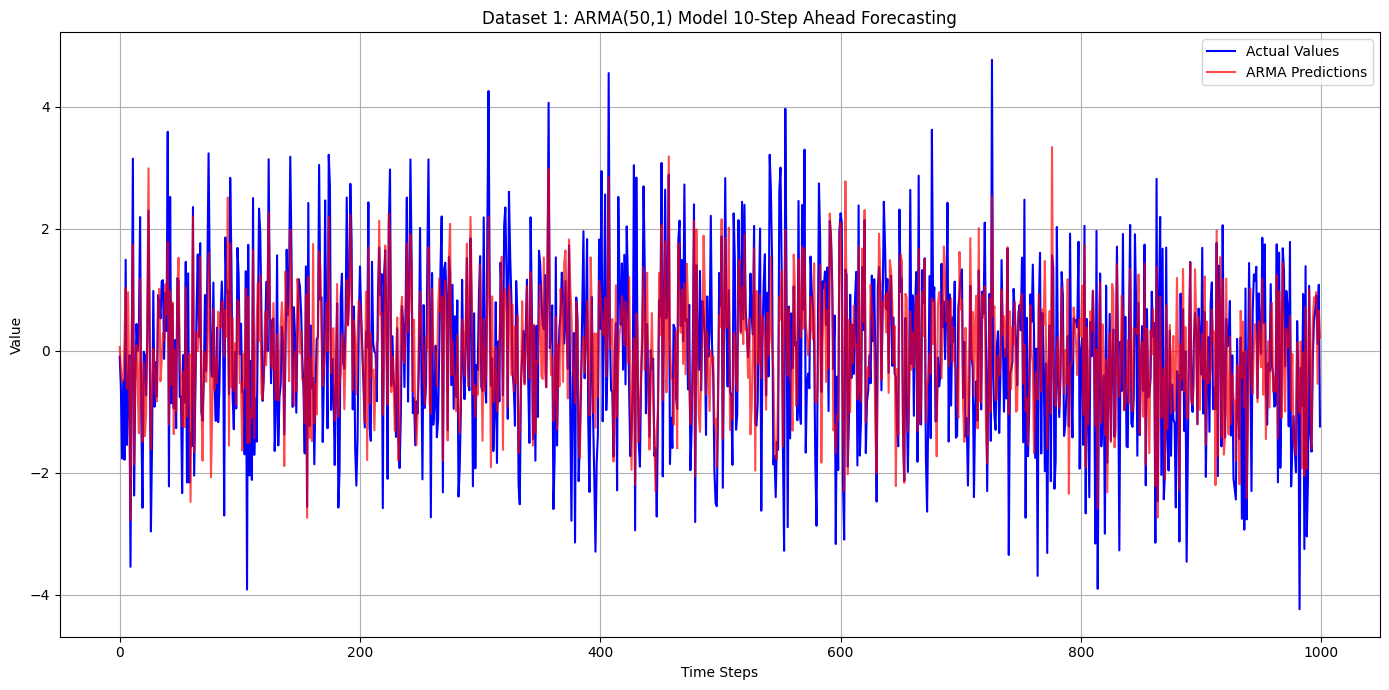


Evaluating dataset 2: dataset2_ARMA-Long-Dependency_raw_length5000.csv
Dataset 2 results:
Mean Squared Error (MSE): 1.031686
Mean Absolute Error (MAE): 0.810014
Root Mean Squared Error (RMSE): 1.015719


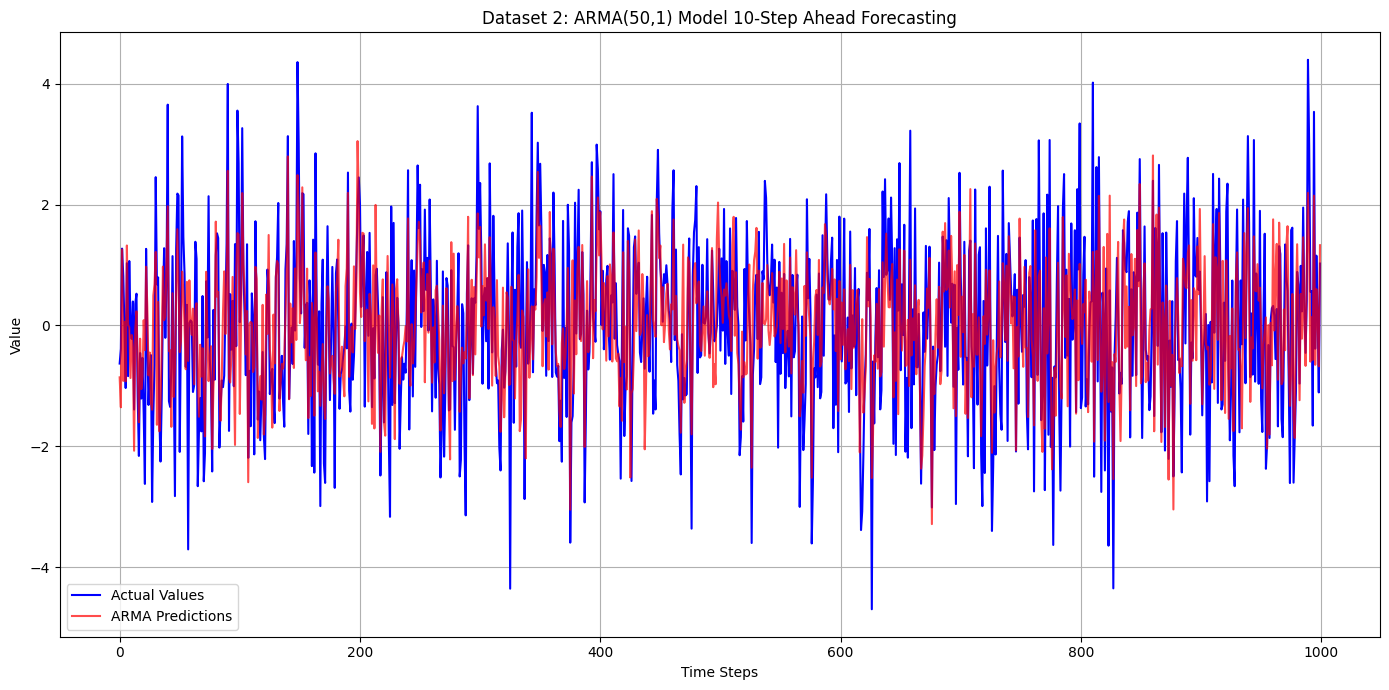


Evaluating dataset 3: dataset3_ARMA-Long-Dependency_raw_length5000.csv
Dataset 3 results:
Mean Squared Error (MSE): 0.948773
Mean Absolute Error (MAE): 0.782213
Root Mean Squared Error (RMSE): 0.974050


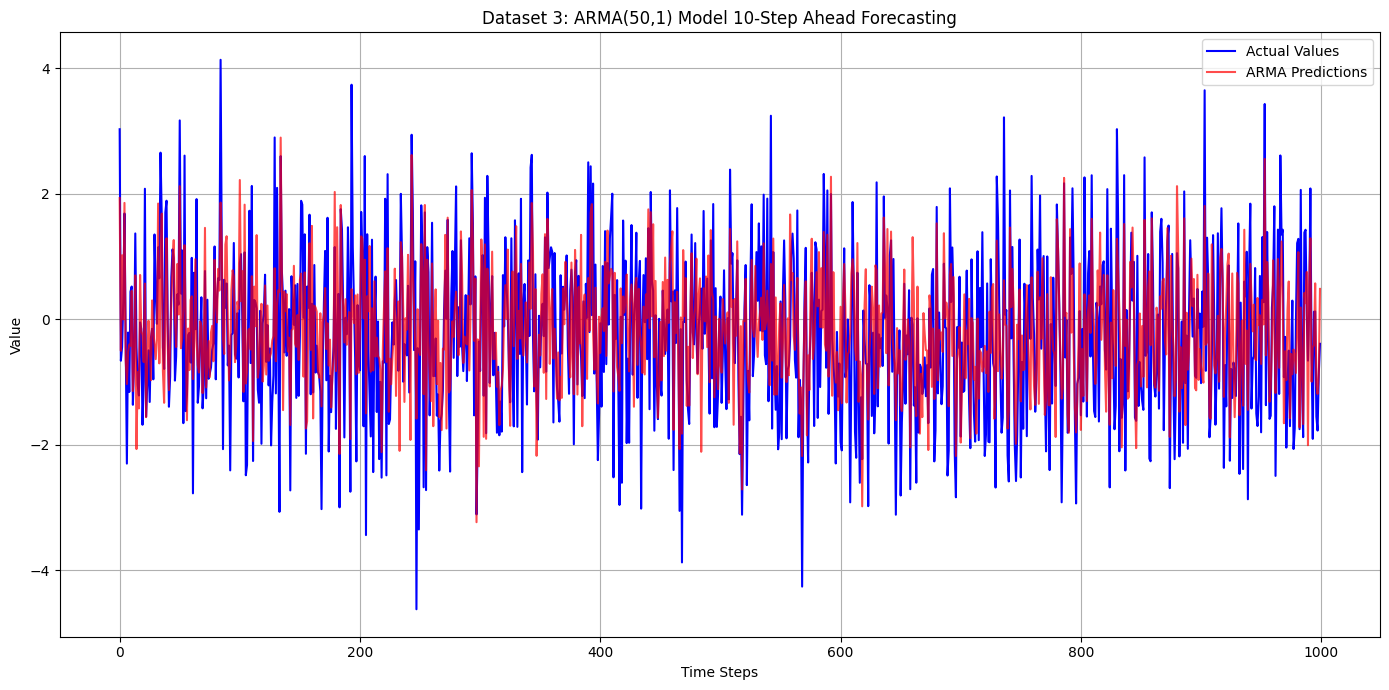


Evaluating dataset 4: dataset4_ARMA-Long-Dependency_raw_length5000.csv
Dataset 4 results:
Mean Squared Error (MSE): 0.973001
Mean Absolute Error (MAE): 0.791302
Root Mean Squared Error (RMSE): 0.986408


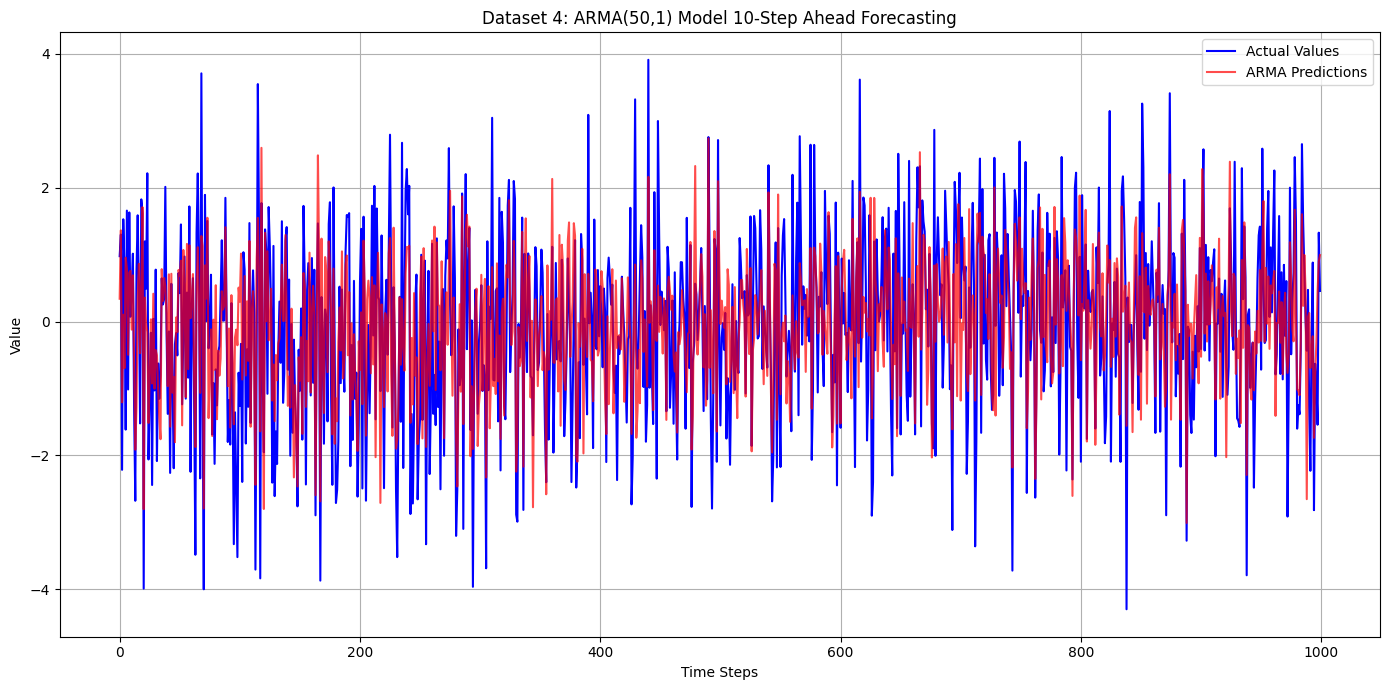


Evaluating dataset 5: dataset5_ARMA-Long-Dependency_raw_length5000.csv
Dataset 5 results:
Mean Squared Error (MSE): 1.050823
Mean Absolute Error (MAE): 0.809295
Root Mean Squared Error (RMSE): 1.025096


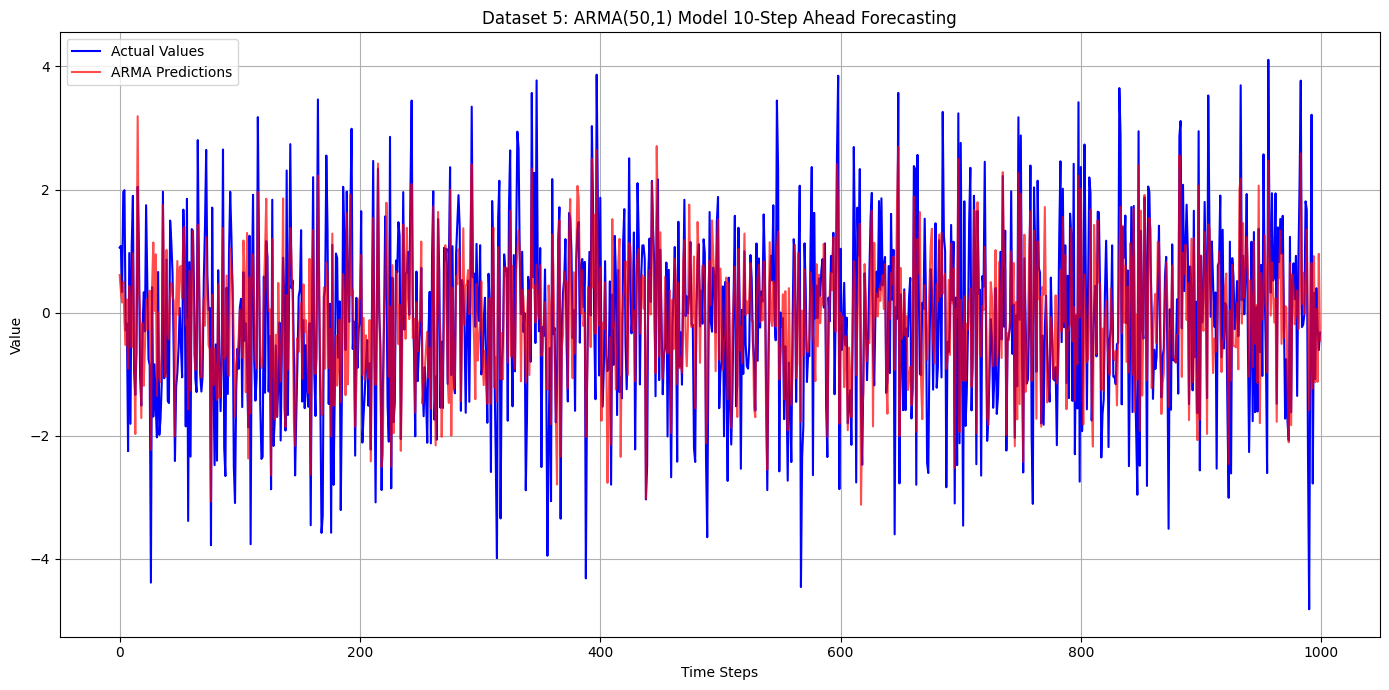


Evaluating dataset 6: dataset6_ARMA-Long-Dependency_raw_length5000.csv
Dataset 6 results:
Mean Squared Error (MSE): 1.019691
Mean Absolute Error (MAE): 0.817863
Root Mean Squared Error (RMSE): 1.009798


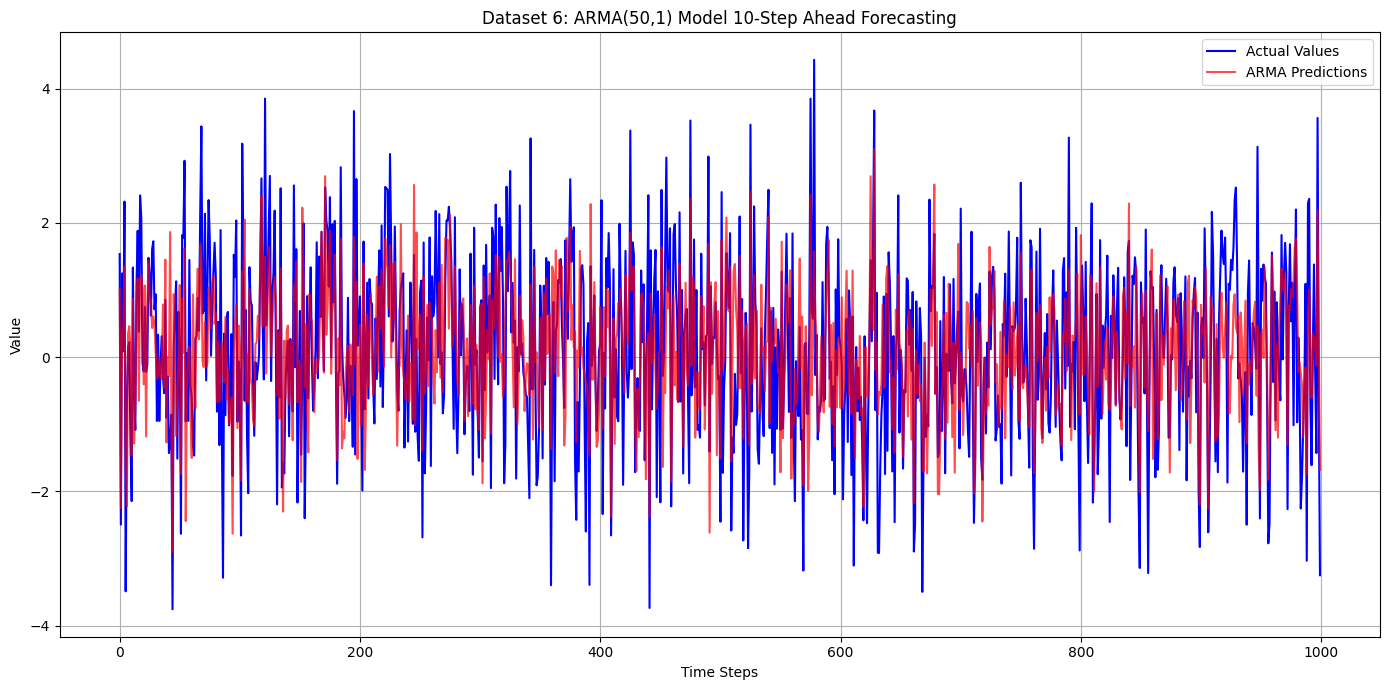


Evaluating dataset 7: dataset7_ARMA-Long-Dependency_raw_length5000.csv
Dataset 7 results:
Mean Squared Error (MSE): 0.980280
Mean Absolute Error (MAE): 0.790846
Root Mean Squared Error (RMSE): 0.990091


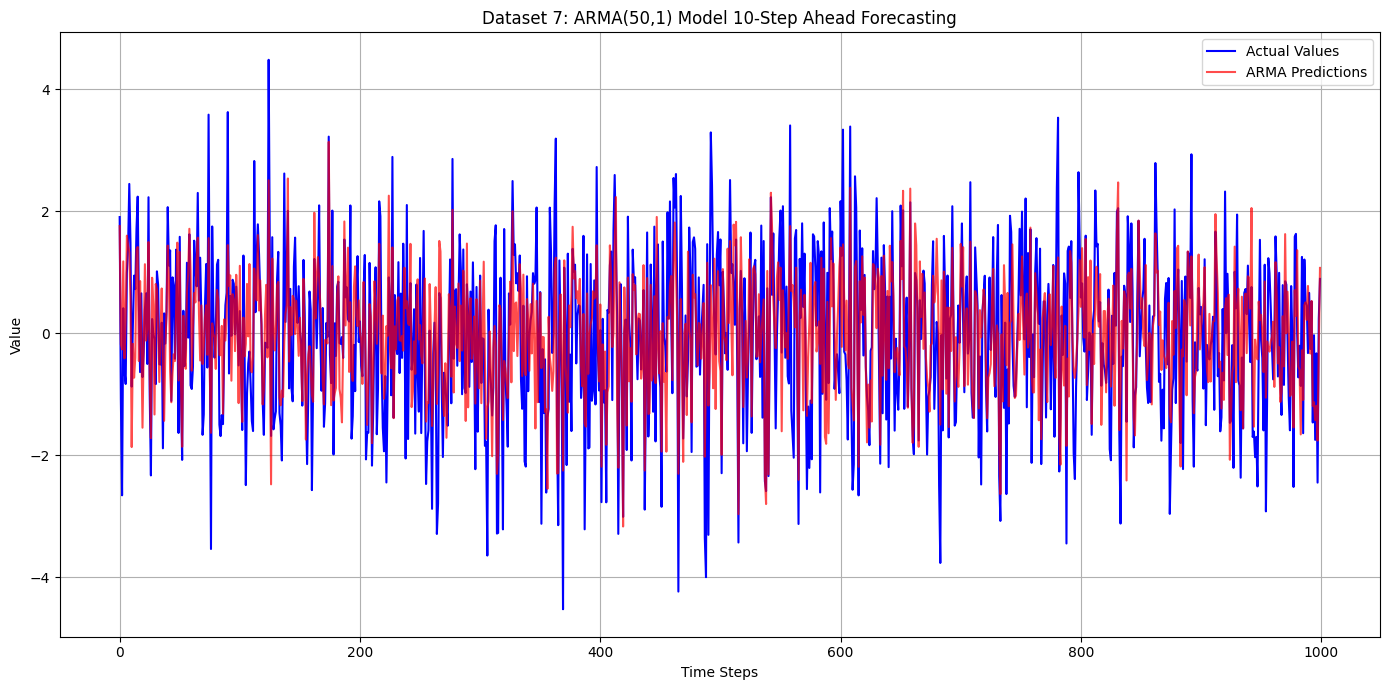


Evaluating dataset 8: dataset8_ARMA-Long-Dependency_raw_length5000.csv
Dataset 8 results:
Mean Squared Error (MSE): 1.004719
Mean Absolute Error (MAE): 0.803003
Root Mean Squared Error (RMSE): 1.002357


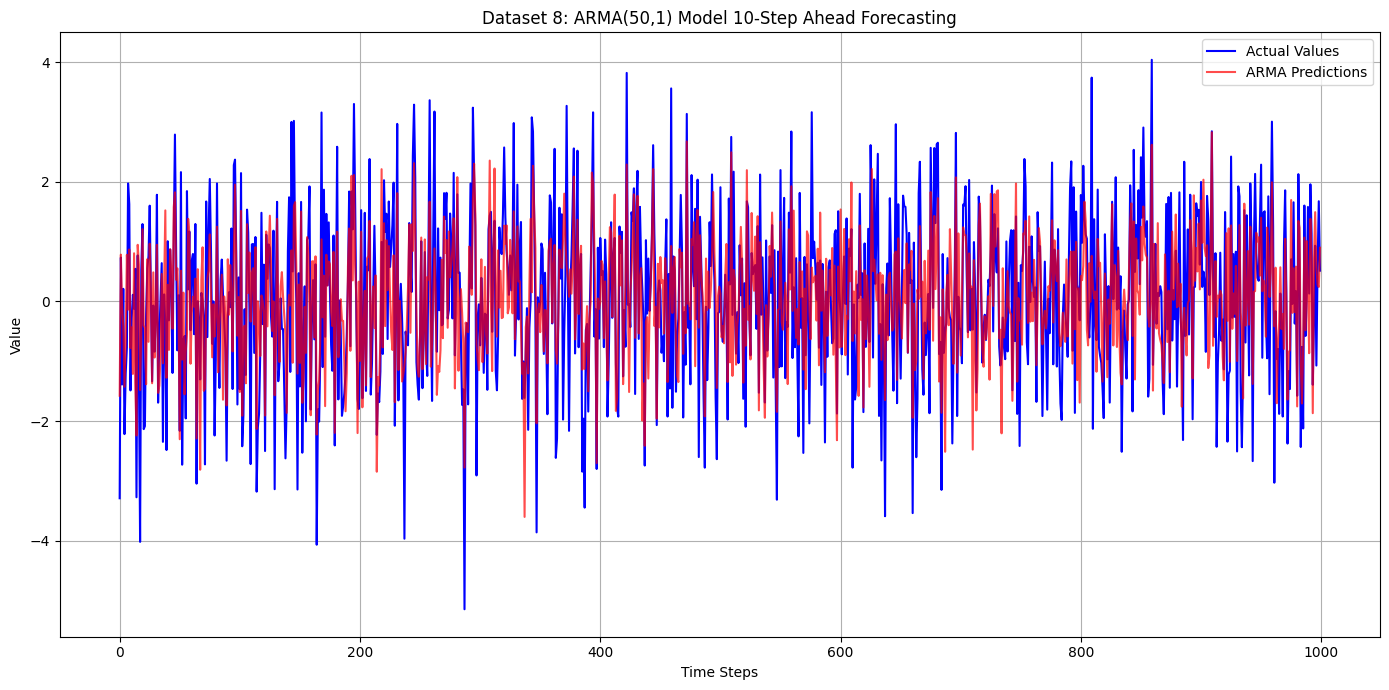


Evaluating dataset 9: dataset9_ARMA-Long-Dependency_raw_length5000.csv
Dataset 9 results:
Mean Squared Error (MSE): 0.972106
Mean Absolute Error (MAE): 0.794000
Root Mean Squared Error (RMSE): 0.985955


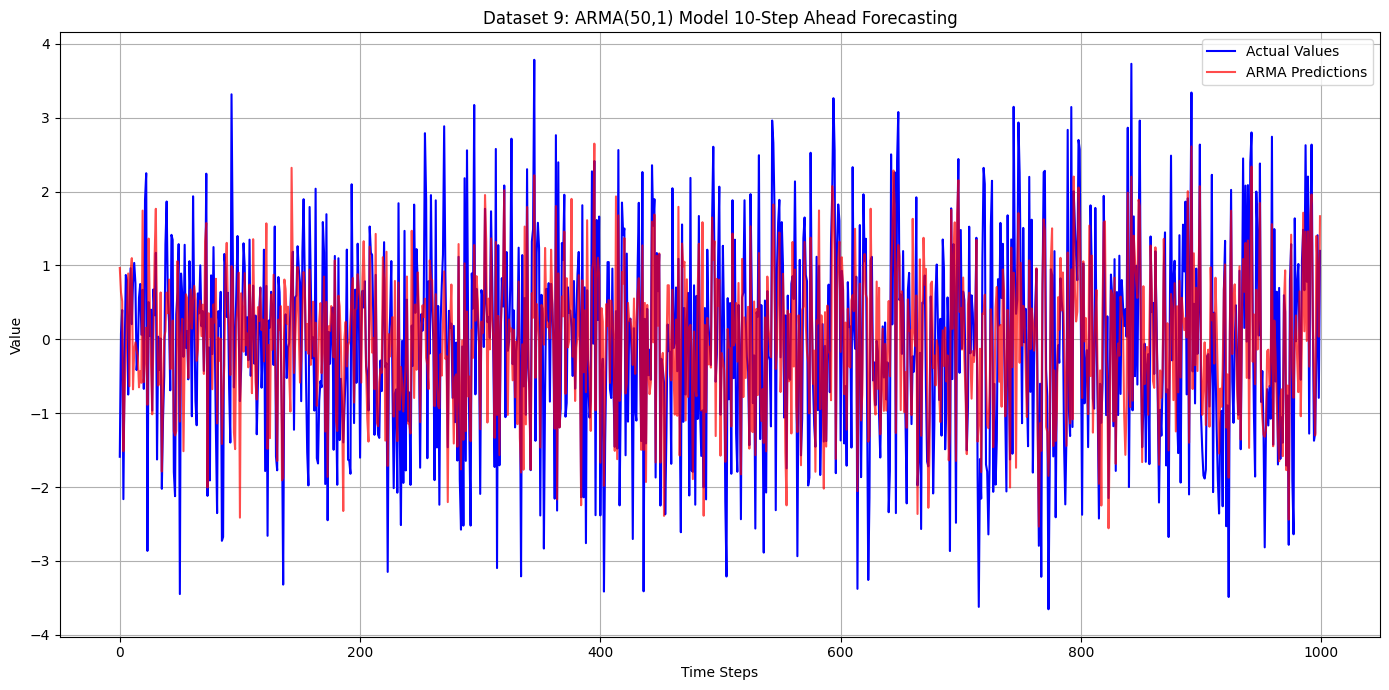


Evaluating dataset 10: dataset10_ARMA-Long-Dependency_raw_length5000.csv
Dataset 10 results:
Mean Squared Error (MSE): 1.052604
Mean Absolute Error (MAE): 0.813151
Root Mean Squared Error (RMSE): 1.025965


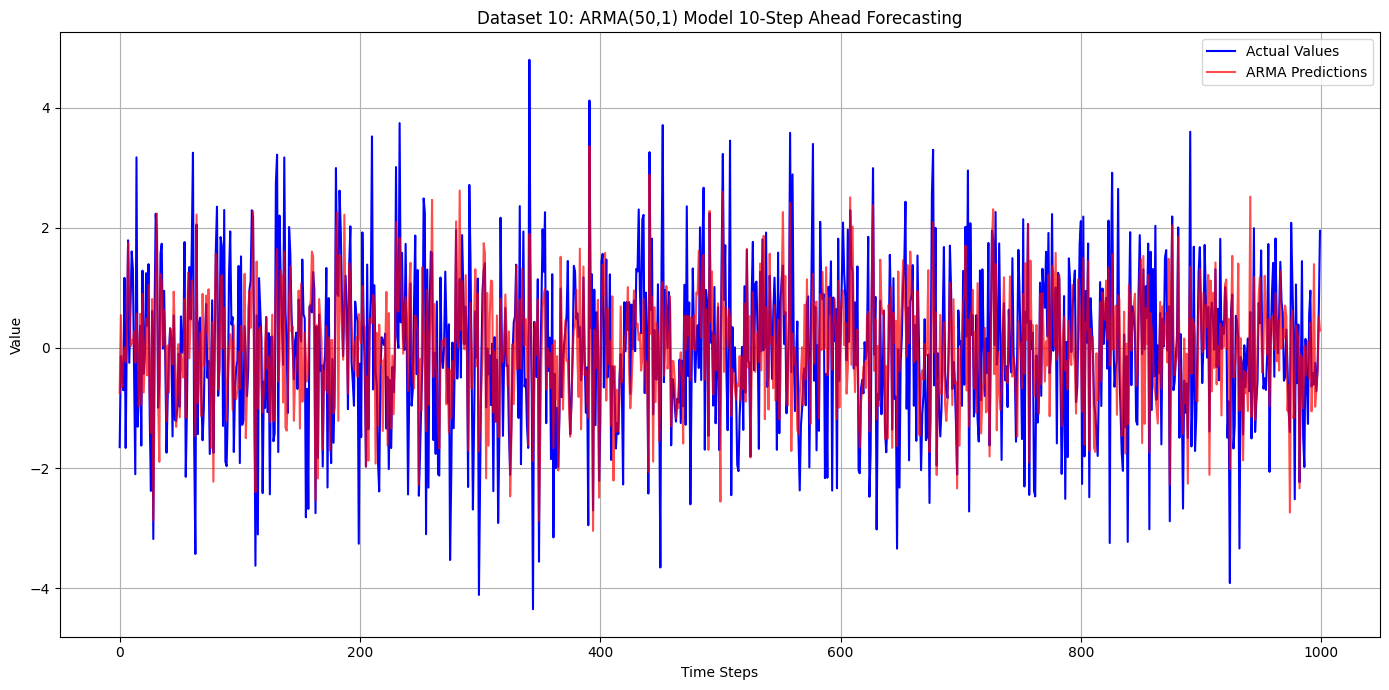


Summary of results across all 10 datasets:
Average Mean Squared Error (MSE): 1.007020 ± 0.034821
Average Mean Absolute Error (MAE): 0.802003 ± 0.011086
Average Root Mean Squared Error (RMSE): 1.003353 ± 0.017382


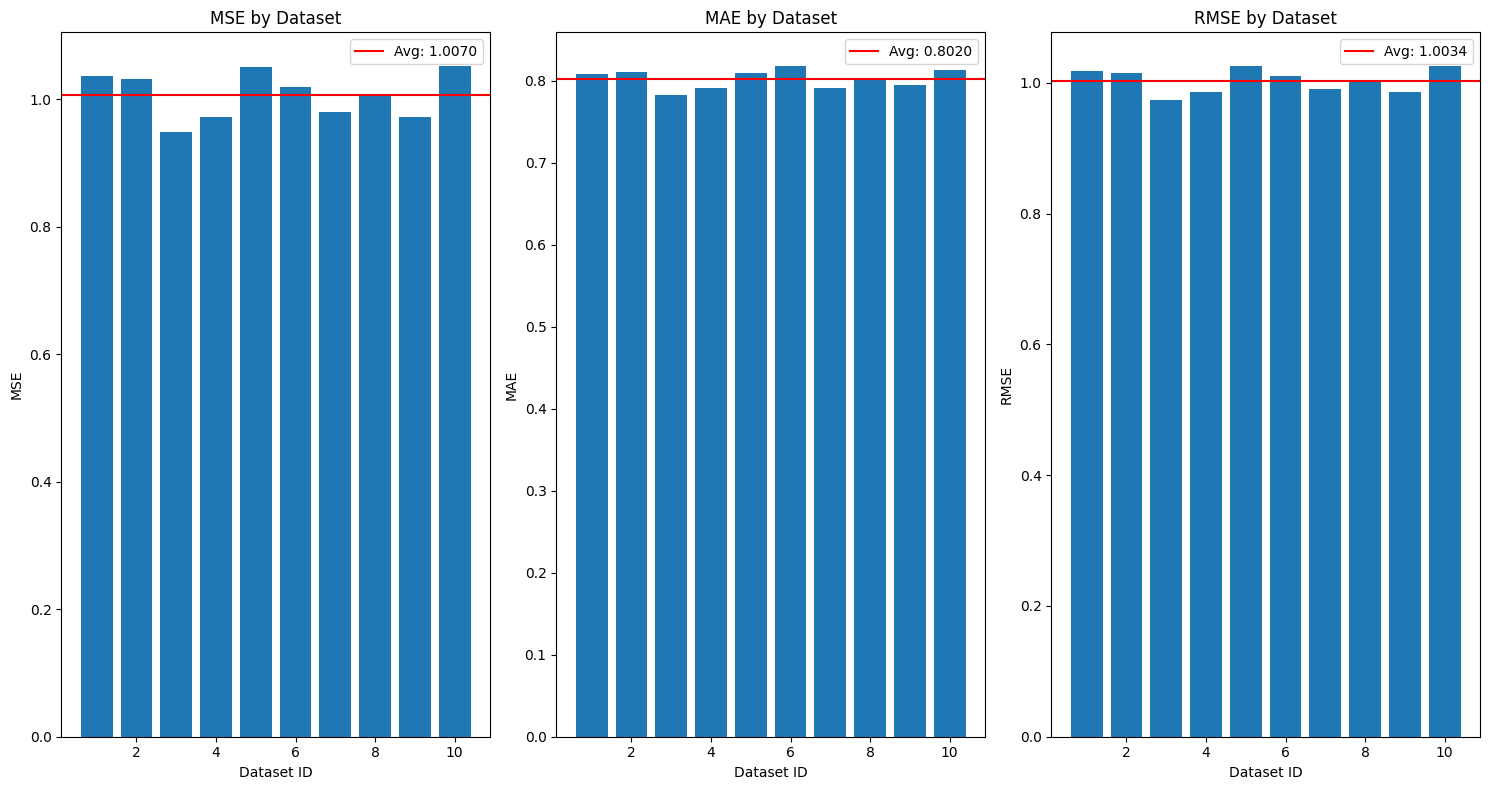

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def load_time_series_data(file_path):
    """Load time series data from CSV file."""
    df = pd.read_csv(file_path)
    return df['Feature1'].values

def predict_with_long_dependency_arma(history, lag=50, ar_coef=0.7, ma_coef=0.3):
    """
    Make a one-step prediction for the long-dependency ARMA model.
    
    Args:
        history: Previous time series values
        lag: The specific lag with non-zero coefficient
        ar_coef: AR coefficient value
        ma_coef: MA coefficient value
    """
    # AR component (depends on value at lag position)
    ar_component = 0
    if len(history) >= lag:
        ar_component = ar_coef * history[-lag]
    
    # MA component (uses prediction error from previous step)
    ma_component = 0
    if len(history) >= lag + 1:
        # Calculate previous prediction and error
        previous_prediction = ar_coef * history[-lag-1]
        prediction_error = history[-1] - previous_prediction
        ma_component = ma_coef * prediction_error
    
    return ar_component + ma_component

def multi_step_forecast(history, steps=10, lag=50, ar_coef=0.7, ma_coef=0.3):
    """
    Make multi-step forecasts using the ARMA model.
    
    Args:
        history: Previous time series values
        steps: Number of steps to forecast ahead
        lag: The specific lag with non-zero coefficient
        ar_coef: AR coefficient value
        ma_coef: MA coefficient value
        
    Returns:
        List of forecasted values for the next 'steps' time points
    """
    forecasts = []
    # Create a copy of history to extend with predictions
    forecast_history = history.copy()
    
    for i in range(steps):
        # Get next prediction
        next_pred = predict_with_long_dependency_arma(
            forecast_history, lag, ar_coef, ma_coef
        )
        forecasts.append(next_pred)
        # Add the prediction to forecast history for next step prediction
        forecast_history.append(next_pred)
    
    return forecasts

def evaluate_arma_model(data, step_size=10, lag=50, ar_coef=0.7, ma_coef=0.3, test_size=0.2):
    """
    Evaluate ARMA model using sliding window approach with specified step size.
    """
    # Split data into train and test (last 20% for testing)
    split_idx = int(len(data) * (1 - test_size))
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    
    # Initialize history with training data
    history = list(train_data)
    
    # Make predictions with the specified step size
    all_predictions = []
    actual_values = []
    
    # Iterate through test data in steps of step_size
    for i in range(0, len(test_data), step_size):
        # Get the actual values for the next step_size positions
        actual_next = test_data[i:i+step_size]
        
        if len(actual_next) < step_size:
            # Skip incomplete final step (less than step_size elements)
            break
            
        # Get predictions for the next step_size steps
        predictions = multi_step_forecast(
            history, steps=step_size, lag=lag, ar_coef=ar_coef, ma_coef=ma_coef
        )
        
        # Add predictions and actual values
        all_predictions.extend(predictions)
        actual_values.extend(actual_next)
        
        # Update history with actual values
        history.extend(actual_next)
    
    # Calculate metrics
    mse = mean_squared_error(actual_values, all_predictions)
    mae = mean_absolute_error(actual_values, all_predictions)
    
    return mse, mae, all_predictions, actual_values

def plot_results(actual, predictions, title="ARMA Model Evaluation", save_path=None):
    """Plot actual values vs predictions."""
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predictions, label='ARMA Predictions', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def find_arma_dataset_files(dataset_folder):
    """Find all ARMA-Long-Dependency dataset files for the 10 datasets."""
    dataset_files = {}
    
    for file in os.listdir(dataset_folder):
        for i in range(1, 11):  # Datasets 1-10
            if f"dataset{i}_ARMA-Long-Dependency_raw" in file:
                dataset_files[i] = os.path.join(dataset_folder, file)
                break
    
    return dataset_files

def main():
    # Dataset folder path
    dataset_folder = "Dataset_generated_ARMA_random"
    
    # Find all ARMA-Long-Dependency files for datasets 1-10
    dataset_files = find_arma_dataset_files(dataset_folder)
    
    if not dataset_files:
        print("Could not find any ARMA-Long-Dependency dataset files.")
        return
    
    print(f"Found {len(dataset_files)} datasets to evaluate")
    
    # Parameters used to generate the data
    lag = 50
    ar_coef = 0.7
    ma_coef = 0
    step_size = 10  # 10-step ahead forecasting
    
    # Store metrics for each dataset
    all_mse = []
    all_mae = []
    all_rmse = []
    
    # Process each dataset
    for dataset_id, file_path in sorted(dataset_files.items()):
        print(f"\nEvaluating dataset {dataset_id}: {os.path.basename(file_path)}")
        
        # Load data
        data = load_time_series_data(file_path)
        
        # Evaluate model
        mse, mae, predictions, actual = evaluate_arma_model(
            data, step_size=step_size, lag=lag, ar_coef=ar_coef, ma_coef=ma_coef
        )
        
        rmse = np.sqrt(mse)
        
        # Store metrics
        all_mse.append(mse)
        all_mae.append(mae)
        all_rmse.append(rmse)
        
        # Print individual dataset metrics
        print(f"Dataset {dataset_id} results:")
        print(f"Mean Squared Error (MSE): {mse:.6f}")
        print(f"Mean Absolute Error (MAE): {mae:.6f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
        
        # Plot results for this dataset
        save_path = f"arma_evaluation_dataset{dataset_id}.png"
        plot_results(
            actual, 
            predictions, 
            title=f"Dataset {dataset_id}: ARMA({lag},1) Model {step_size}-Step Ahead Forecasting",
            save_path=save_path
        )
    
    # Calculate average metrics
    avg_mse = np.mean(all_mse)
    avg_mae = np.mean(all_mae)
    avg_rmse = np.mean(all_rmse)
    
    std_mse = np.std(all_mse)
    std_mae = np.std(all_mae)
    std_rmse = np.std(all_rmse)
    
    # Print summary of results
    print("\n" + "="*50)
    print(f"Summary of results across all {len(dataset_files)} datasets:")
    print(f"Average Mean Squared Error (MSE): {avg_mse:.6f} ± {std_mse:.6f}")
    print(f"Average Mean Absolute Error (MAE): {avg_mae:.6f} ± {std_mae:.6f}")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse:.6f} ± {std_rmse:.6f}")
    print("="*50)
    
    # Create a summary plot of metrics across datasets
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(1, len(all_mse)+1), all_mse)
    plt.axhline(y=avg_mse, color='r', linestyle='-', label=f'Avg: {avg_mse:.4f}')
    plt.title('MSE by Dataset')
    plt.xlabel('Dataset ID')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.bar(range(1, len(all_mae)+1), all_mae)
    plt.axhline(y=avg_mae, color='r', linestyle='-', label=f'Avg: {avg_mae:.4f}')
    plt.title('MAE by Dataset')
    plt.xlabel('Dataset ID')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.bar(range(1, len(all_rmse)+1), all_rmse)
    plt.axhline(y=avg_rmse, color='r', linestyle='-', label=f'Avg: {avg_rmse:.4f}')
    plt.title('RMSE by Dataset')
    plt.xlabel('Dataset ID')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('arma_evaluation_summary.png')
    plt.show()
    
    return avg_mse, avg_mae, avg_rmse

if __name__ == "__main__":
    main()